In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import seaborn as sns
import sys
import copy
from tqdm.notebook import tqdm
from scipy import stats
import networkx as nx
import random
import re
from validation_functions import *

# plt.style.use('seaborn-deep')
plt.rcParams["text.usetex"] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{amssymb,amsmath}'

plt.rcParams["figure.figsize"] = 11.7, 8.3
plt.rcParams["figure.dpi"] = 75

plt.rcParams["font.size"] = 22
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = ["Fira Sans", 'PT Sans', 'Open Sans', 'Roboto', 'DejaVu Sans', 'Liberation Sans', 'sans-serif']

plt.rcParams["legend.frameon"] = True
plt.rcParams["legend.fancybox"] = True
plt.rcParams["legend.fontsize"] = "small"

plt.rcParams["lines.linewidth"] = 2.5
plt.rcParams["lines.markersize"] = 14
plt.rcParams["lines.markeredgewidth"] = 2

plt.rcParams["xtick.major.size"] = 8
plt.rcParams["ytick.major.size"] = 8

In [2]:
def read_inf_coords(dim, path):
    df = pd.read_csv(path, sep="\s+", header=None, comment="#")
    if dim == 1:
        df.columns = ['index', 'inf_kappa', 'inf_theta', 'inf_radius']
    else:
        cols = [f'inf_p{i}' for i in range(dim+1)]
        df.columns = ['index', 'inf_kappa', 'inf_radius', *cols]
    return df


def read_all_coordinates(dim ,folder):
    inf_coord_files = glob.glob(f'{folder}/*inf_coord*')
    for file in inf_coord_files:
        if 'features_le' in file:
            inf_coord_features_le = read_inf_coords(dim, file)
        elif 'nodes_le' in file:
            inf_coord_nodes_le = read_inf_coords(dim, file)
        elif 'features' in file:
            inf_coord_features = read_inf_coords(dim, file)
        elif 'nodes' in file:
            inf_coord_nodes = read_inf_coords(dim, file)
        elif '_raw' in file:
            ''
        elif 'coord_le' in file:
            inf_coord_le = read_inf_coords(dim, file)
        else:
            inf_coord = read_inf_coords(dim, file)
        
    # Merge inferred and generated coordinates
    # 1. Coordinates of nodes in bipartite
    # 2. Coordinates of features in bipartite
    df_nodes = inf_coord_nodes.merge(inf_coord_nodes_le, on='index', suffixes=('', '_le'))
    df_features = inf_coord_features.merge(inf_coord_features_le, on='index', suffixes=('', '_le'))
    return df_nodes, df_features

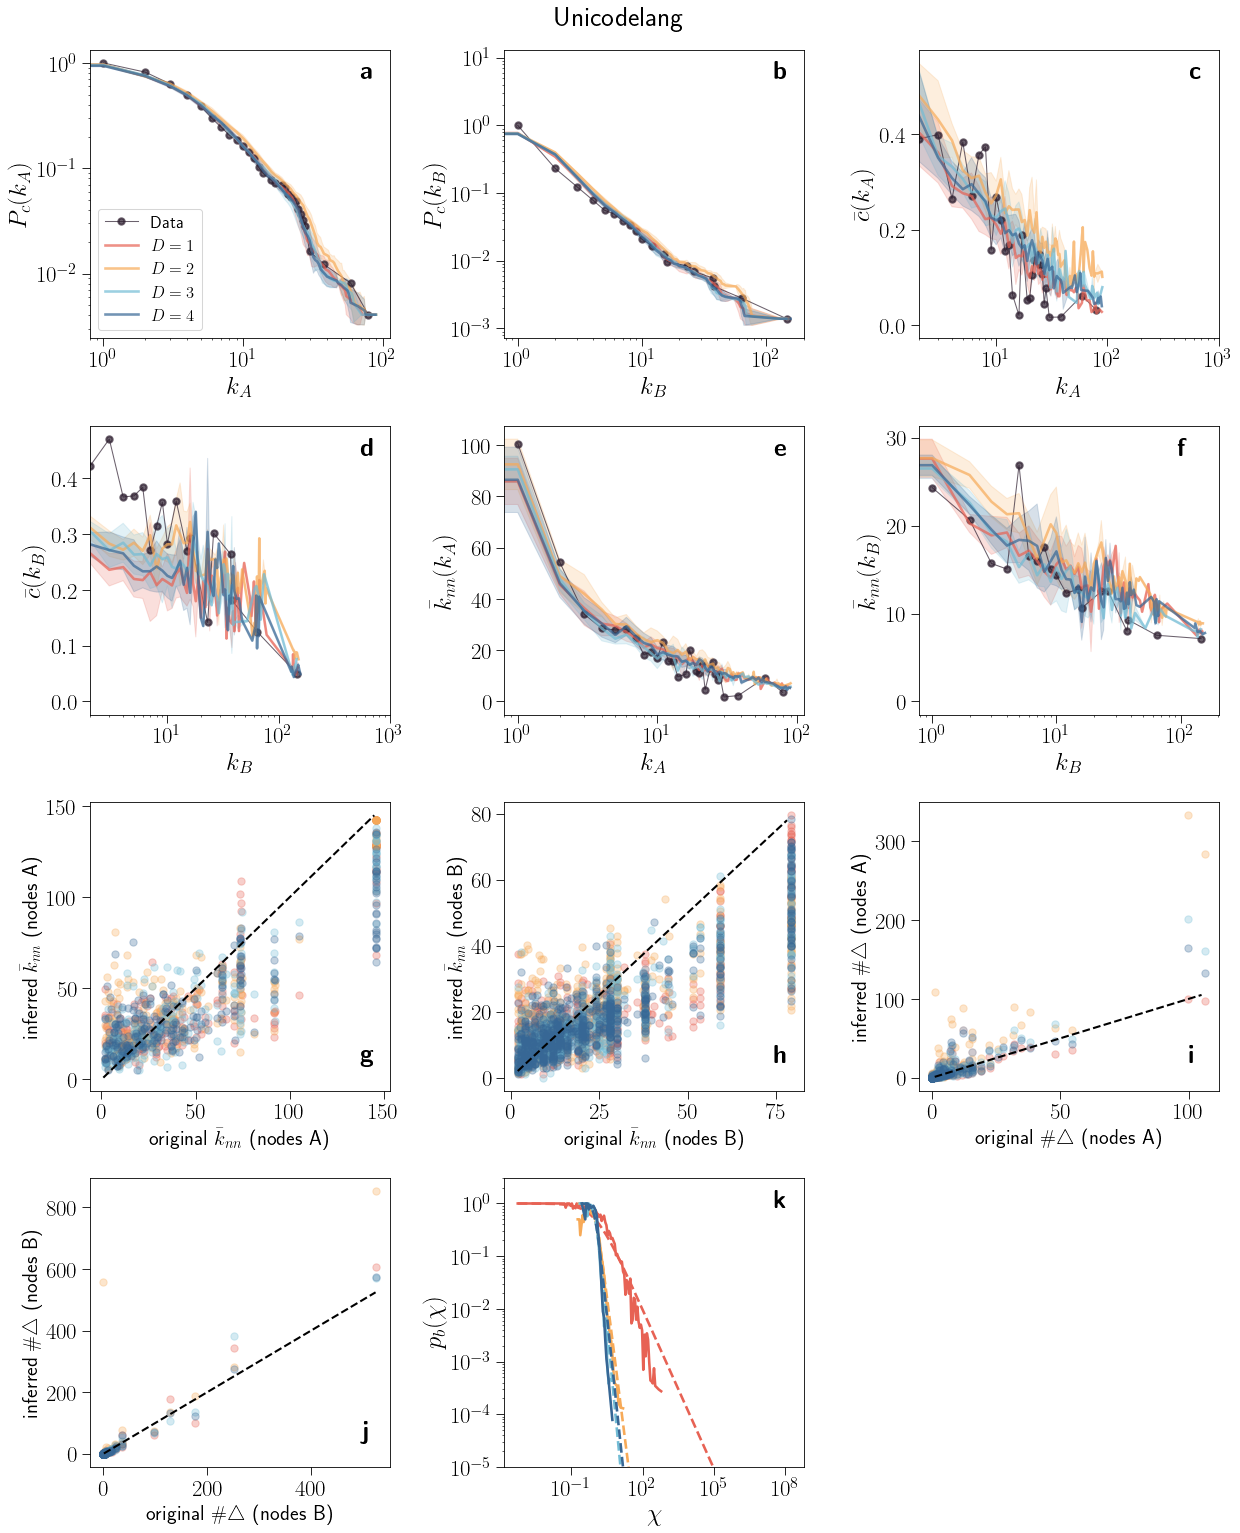

In [3]:
base_path = "/home/rob/MEGAsync/datasets/networks/bipartite_networks/unicodelang/"

filename = 'country_lang_GCC'

paths = [f"{base_path}/eS{d}" for d in [1, 2, 3, 4]]
labels = [rf'$D={d}$' for d in [1, 2, 3, 4]]


# Bipartite
dfs_vstats_bipartite_nodes = [load_vstats_bipartite_nodes(p, filename) for p in paths]
dfs_vstats_bipartite_features = [load_vstats_bipartite_features(p, filename) for p in paths]

df_vprop_bipartite_nodes = [load_vprops_bipartite_nodes(p, filename) for p in paths]
df_vprop_bipartite_features = [load_vprops_bipartite_features(p, filename) for p in paths]

df_obs_bipartite_nodes = load_vstat_obs_bipartite_nodes(paths[0], filename)
df_obs_bipartite_features = load_vstat_obs_bipartite_features(paths[0], filename)
df_pconns_bipartite = [load_bipartite_pcon(p, filename) for p in paths]

#########################
plt.figure(figsize=(17, 21))
plt.subplot(4, 3, 1)
plot_degree_distribution(df_obs_bipartite_nodes, dfs_vstats_bipartite_nodes, labels, xlabel=r'$k_A$',
                         ylabel=r'$P_c(k_A)$')
plt.legend(loc='lower left', fontsize=16)
plt.text(0.9, 0.9, r'$\textbf{a}$', fontsize=24, transform=plt.gca().transAxes)

plt.subplot(4, 3, 2)
plot_degree_distribution(df_obs_bipartite_features, dfs_vstats_bipartite_features, labels, xlabel=r'$k_B$',
                         ylabel=r'$P_c(k_B)$')
plt.text(0.9, 0.9, r'$\textbf{b}$', fontsize=24, transform=plt.gca().transAxes)

plt.subplot(4, 3, 3)
plot_clustering_coefficient(df_obs_bipartite_nodes, dfs_vstats_bipartite_nodes, labels, xlabel=r'$k_A$',
                         ylabel=r'$\bar{c}(k_A)$')
plt.xlim(2, 1000)
plt.text(0.9, 0.9, r'$\textbf{c}$', fontsize=24, transform=plt.gca().transAxes)

plt.subplot(4, 3, 4)
plot_clustering_coefficient(df_obs_bipartite_features, dfs_vstats_bipartite_features, labels, xlabel=r'$k_B$',
                         ylabel=r'$\bar{c}(k_B)$')
plt.xlim(2, 1000)
plt.text(0.9, 0.9, r'$\textbf{d}$', fontsize=24, transform=plt.gca().transAxes)

plt.subplot(4, 3, 5)
plot_average_degree_neighbour(df_obs_bipartite_nodes, dfs_vstats_bipartite_nodes, labels,
                              xlabel=r'$k_A$', ylabel=r"$\bar{k}_{nn}(k_A)$")
plt.text(0.9, 0.9, r'$\textbf{e}$', fontsize=24, transform=plt.gca().transAxes)

plt.subplot(4, 3, 6)
plot_average_degree_neighbour(df_obs_bipartite_features, dfs_vstats_bipartite_features, labels,
                              xlabel=r'$k_B$', ylabel=r"$\bar{k}_{nn}(k_B)$")
plt.text(0.86, 0.9, r'$\textbf{f}$', fontsize=24, transform=plt.gca().transAxes)

plt.subplot(4, 3, 7)
plot_sum_degree_neighbours(df_vprop_bipartite_nodes, labels, additional_label=' (nodes A)', 
                           log_scale=False)
plt.text(0.9, 0.1, r'$\textbf{g}$', fontsize=24, transform=plt.gca().transAxes)

plt.subplot(4, 3, 8)
plot_sum_degree_neighbours(df_vprop_bipartite_features, labels, additional_label=' (nodes B)',
                           log_scale=False)
plt.text(0.9, 0.1, r'$\textbf{h}$', fontsize=24, transform=plt.gca().transAxes)

plt.subplot(4, 3, 9)
plot_number_of_triangles(df_vprop_bipartite_nodes, labels, additional_label=' (nodes A)', 
                         log_scale=False)
plt.text(0.9, 0.1, r'$\textbf{i}$', fontsize=24, transform=plt.gca().transAxes)

plt.subplot(4, 3, 10)
plot_number_of_triangles(df_vprop_bipartite_features, labels, additional_label=' (nodes B)', 
                         log_scale=False)
plt.text(0.9, 0.1, r'$\textbf{j}$', fontsize=24, transform=plt.gca().transAxes)

plt.subplot(4, 3, 11)
plot_connection_probabilities(df_pconns_bipartite, labels, ylabel=r'$p_b(\chi)$')
plt.text(0.9, 0.9, r'$\textbf{k}$', fontsize=24, transform=plt.gca().transAxes)

plt.suptitle(r'Unicodelang', y=0.98)
plt.tight_layout()

# plt.savefig("/home/rob/Dropbox/Robert/FeatureMercator/Reports/unicodelang-dataset-13-11-24/plots/unicodelang_validation.pdf")

# plt.savefig("/home/rob/Dropbox/Robert/FeatureMercator/Paper/SI/plots/unicodelang_validation.pdf")

In [4]:
p = "/home/rob/MEGAsync/datasets/networks/bipartite_networks/unicodelang/"

df_nodes_S1, df_features_S1 = read_all_coordinates(1, f"{p}/eS1")
df_nodes_S2, df_features_S2 = read_all_coordinates(2, f"{p}/eS2")
df_nodes_S3, df_features_S3 = read_all_coordinates(3, f"{p}/eS3")
df_nodes_S4, df_features_S4 = read_all_coordinates(4, f"{p}/eS4")

In [5]:
df_countries = pd.read_csv("/home/rob/MEGAsync/datasets/networks/bipartite_networks/unicodelang/df_countries.csv")

df_nodes_S1 = pd.merge(df_nodes_S1, df_countries, left_on='index', right_on='Territory')
df_nodes_S2 = pd.merge(df_nodes_S2, df_countries, left_on='index', right_on='Territory')
df_nodes_S3 = pd.merge(df_nodes_S3, df_countries, left_on='index', right_on='Territory')
df_nodes_S4 = pd.merge(df_nodes_S4, df_countries, left_on='index', right_on='Territory')


In [6]:
df_nodes_S1.head()

,index,inf_kappa,inf_theta,inf_radius,inf_kappa_le,inf_theta_le,inf_radius_le,Territory,Name,Population,...,alpha-2,alpha-3,country-code,iso_3166-2,region,sub-region,intermediate-region,region-code,sub-region-code,intermediate-region-code
0,AD,18.16440,1.86452,17.5722,10.30220,1.86452,18.7064,AD,Andorra,85370,...,AD,AND,20,ISO 3166-2:AD,Europe,Southern Europe,NaN,150.0,39.0,NaN
1,AE,28.55950,1.96669,16.6672,25.87300,1.96669,16.8648,AE,United Arab Emirates,10032200,...,AE,ARE,784,ISO 3166-2:AE,Asia,Western Asia,NaN,142.0,145.0,NaN
2,AF,58.90140,2.75847,15.2194,51.48520,2.75847,15.4886,AF,Afghanistan,40121600,...,AF,AFG,4,ISO 3166-2:AF,Asia,Southern Asia,NaN,142.0,34.0,NaN
3,AG,6.28175,1.17883,19.6959,6.07429,1.25153,19.7630,AG,Antigua & Barbuda,102634,...,AG,ATG,28,ISO 3166-2:AG,Americas,Latin America and the Caribbean,Caribbean,19.0,419.0,29.0
4,AI,1.05060,5.72460,23.2725,2.51949,5.95115,21.5231,AI,Anguilla,19416,...,AI,AIA,660,ISO 3166-2:AI,Americas,Latin America and the Caribbean,Caribbean,19.0,419.0,29.0


In [7]:
df_lang = pd.read_csv("/home/rob/MEGAsync/datasets/networks/bipartite_networks/unicodelang/language_scripts_cleaned.csv")

df_features_S1 = pd.merge(df_features_S1, df_lang, left_on='index', right_on='Language Type')
df_features_S2 = pd.merge(df_features_S2, df_lang, left_on='index', right_on='Language Type')
df_features_S3 = pd.merge(df_features_S3, df_lang, left_on='index', right_on='Language Type')
df_features_S4 = pd.merge(df_features_S4, df_lang, left_on='index', right_on='Language Type')


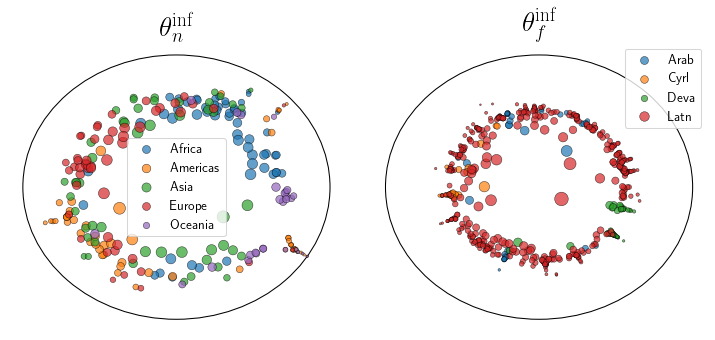

In [8]:
from matplotlib.patches import Circle

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

for name, group in df_nodes_S1.groupby("region"):
    group['x'] = group['inf_radius'] * np.cos(group['inf_theta'])
    group['y'] = group['inf_radius'] * np.sin(group['inf_theta'])    
    axs[0].scatter(group['x'], group['y'], s=20*np.log(group['inf_kappa'] + 1), 
                   edgecolors='black', alpha=0.7, linewidths=0.5, zorder=2, label=name)

max_radius = df_nodes_S1['inf_radius'].max()
circle = Circle((0, 0), max_radius, color='black', fill=False, linestyle='-', linewidth=1)
axs[0].add_patch(circle)

axs[0].legend(fontsize=13)

for name, group in df_features_S1.groupby("Scripts"):
    if len(group) > 10:
        group['x'] = group['inf_radius'] * np.cos(group['inf_theta'])
        group['y'] = group['inf_radius'] * np.sin(group['inf_theta']) 
        axs[1].scatter(group['x'], group['y'], s=20*np.log(group['inf_kappa'] + 1), label=name,
                       edgecolors='black', alpha=0.7, linewidths=0.5, zorder=2)


max_radius = df_features_S1['inf_radius'].max()
circle = Circle((0, 0), max_radius, color='black', fill=False, linestyle='-', linewidth=1)
axs[1].add_patch(circle)

axs[1].legend(fontsize=13)

axs[0].set_title(r'$\theta_n^{\mathrm{inf}}$')
axs[1].set_title(r'$\theta_f^{\mathrm{inf}}$')
axs[0].axis('off')
axs[1].axis('off')

plt.tight_layout()

# plt.savefig("/home/rob/Dropbox/Robert/FeatureMercator/Reports/unicodelang-dataset-13-11-24/plots/unicodelang_S1_viz.pdf")


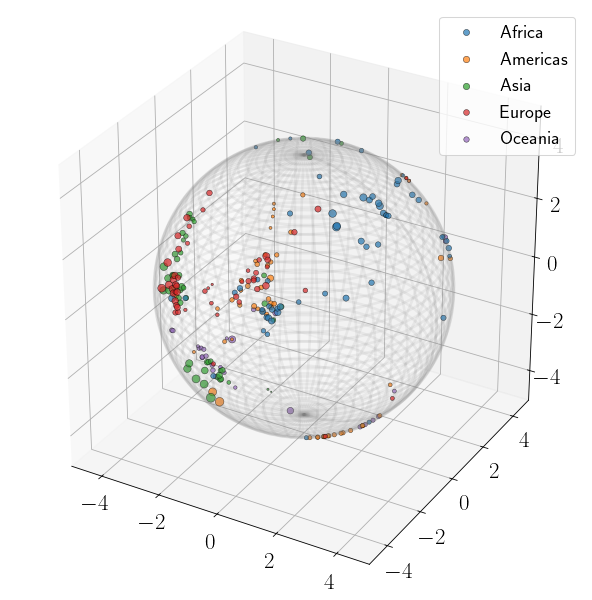

In [9]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

for name, group in df_nodes_S2.groupby("region"):
    ax.scatter(group['inf_p0'], group['inf_p1'], group['inf_p2'], 
               s=20*np.log(group['inf_kappa'] + 1), label=name,
               edgecolors='black', alpha=0.7, linewidths=0.5, zorder=2)
      
ax.legend()
radius = np.linalg.norm(df_nodes_S2[['inf_p0', 'inf_p1', 'inf_p2']].values[0])
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
x = radius * np.outer(np.cos(u), np.sin(v))
y = radius * np.outer(np.sin(u), np.sin(v))
z = radius * np.outer(np.ones(np.size(u)), np.cos(v))
ax.plot_wireframe(x, y, z, color='grey', alpha=0.1, zorder=0)
ax.set_box_aspect([1, 1, 1])

# plt.savefig("/home/rob/Dropbox/Robert/FeatureMercator/Reports/unicodelang-dataset-13-11-24/plots/unicodelang_S2_countries.pdf")


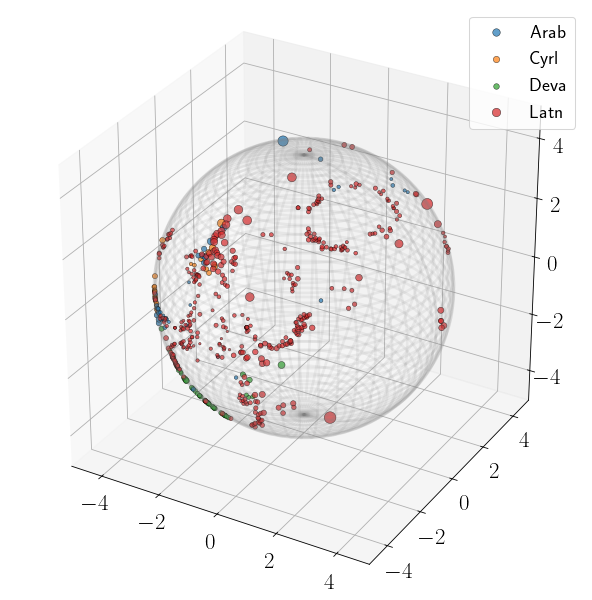

In [10]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

for name, group in df_features_S2.groupby("Scripts"):
    if len(group) > 10:
        ax.scatter(group['inf_p0'], group['inf_p1'], group['inf_p2'], 
                   s=20*np.log(group['inf_kappa'] + 1),
                   edgecolors='black', alpha=0.7, linewidths=0.5, zorder=2, marker='o', label=name)

ax.legend()
radius = np.linalg.norm(df_nodes_S2[['inf_p0', 'inf_p1', 'inf_p2']].values[0])
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
x = radius * np.outer(np.cos(u), np.sin(v))
y = radius * np.outer(np.sin(u), np.sin(v))
z = radius * np.outer(np.ones(np.size(u)), np.cos(v))
ax.plot_wireframe(x, y, z, color='grey', alpha=0.1, zorder=0)
ax.set_box_aspect([1, 1, 1])

# plt.savefig("/home/rob/Dropbox/Robert/FeatureMercator/Reports/unicodelang-dataset-13-11-24/plots/unicodelang_S2_lang.pdf")


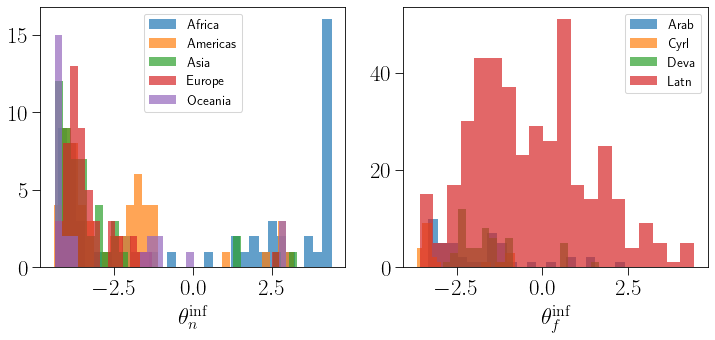

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

for name, group in df_nodes_S2.groupby("region"):    
    axs[0].hist(group['inf_p1'], alpha=0.7, zorder=2, label=name, bins=30)

axs[0].legend(fontsize=13)

for name, group in df_features_S2.groupby("Scripts"):
    if len(group) > 10:
        axs[1].hist(group['inf_p0'], alpha=0.7, zorder=2, label=name, bins=20)
    
axs[1].legend(fontsize=13)

axs[0].set_xlabel(r'$\theta_n^{\mathrm{inf}}$')
axs[1].set_xlabel(r'$\theta_f^{\mathrm{inf}}$')

plt.tight_layout()

In [12]:
df_features_S1[df_features_S1['inf_radius'] > 30]

,index,inf_kappa,inf_theta,inf_radius,inf_kappa_le,inf_theta_le,inf_radius_le,Language Type,Language Name,Scripts
530,pon,0.000897,0.0,37.405,1.8273,0.0,20.7792,pon,Pohnpeian,Latn


In [13]:
df_nodes_S1[df_nodes_S1['inf_radius'] > 30]

,index,inf_kappa,inf_theta,inf_radius,inf_kappa_le,inf_theta_le,inf_radius_le,Territory,Name,Population,...,alpha-2,alpha-3,country-code,iso_3166-2,region,sub-region,intermediate-region,region-code,sub-region-code,intermediate-region-code


In [14]:
df_nodes_S1[df_nodes_S1['index'] == 'fan']

,index,inf_kappa,inf_theta,inf_radius,inf_kappa_le,inf_theta_le,inf_radius_le,Territory,Name,Population,...,alpha-2,alpha-3,country-code,iso_3166-2,region,sub-region,intermediate-region,region-code,sub-region-code,intermediate-region-code


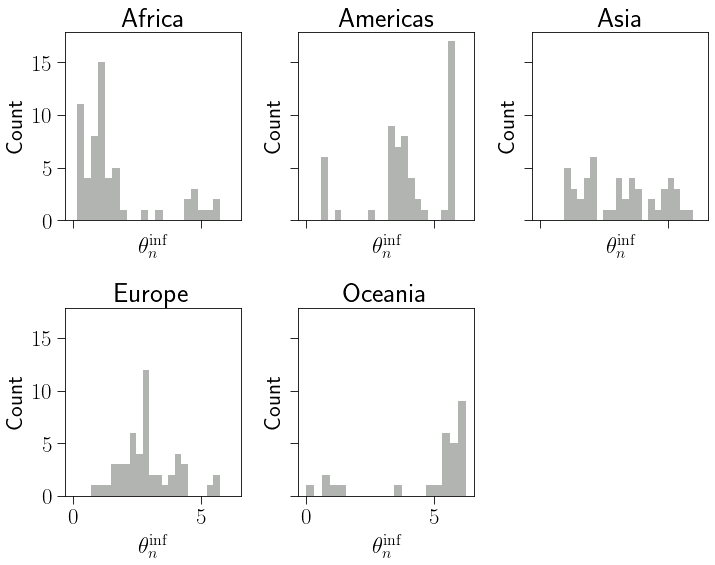

In [15]:
fig, axs = plt.subplots(2, 3, figsize=(10, 8), sharex=True, sharey=True)

colors = [
  "#e76254",
  "#ef8a47",
  "#f7aa58",
  "#ffd06f",
  "#ffe6b7",
  "#aadce0",
  "#72bcd5",
  "#528fad",
  "#376795",
  "#1e466e"
][::2]

axs = axs.flatten()

i = 0
for (name, group) in df_nodes_S1.groupby("region"):
  
    ax = axs[i]
    ax.hist(group['inf_theta'], alpha=0.7, bins=20, color='xkcd:grey')
    
#     j = 0
#     for (name2, group2) in df_features_S1.groupby("Scripts"):
#         if len(group2) > 10:
#             ax.hist(group2['inf_theta'], alpha=0.7, bins=20, color=colors[j], label=name2)
#             j += 1

    ax.set_title(name)
    ax.set_xlabel(r'$\theta_n^{\mathrm{inf}}$')
    ax.set_ylabel('Count')
    
    i += 1

        
axs[-1].axis('off')
plt.tight_layout()
plt.show()


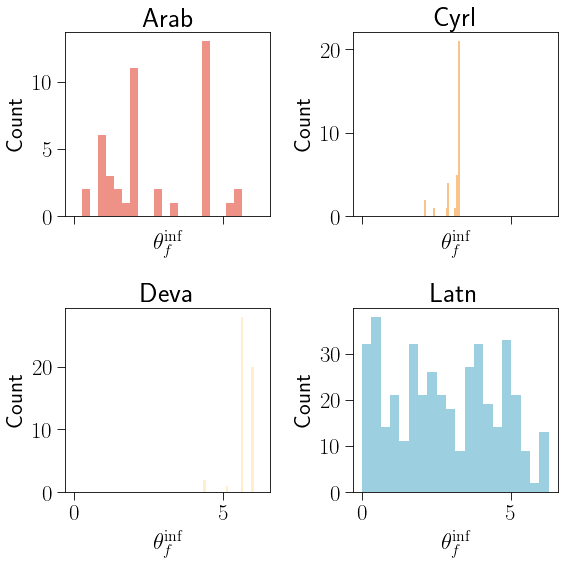

In [16]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8), sharex=True)

axs = axs.flatten()

i = 0
for (name, group) in df_features_S1.groupby("Scripts"):
    if len(group) > 10:
        ax = axs[i]
        ax.hist(group['inf_theta'], alpha=0.7, bins=20, color=colors[i])
        ax.set_title(name)
        ax.set_xlabel(r'$\theta_f^{\mathrm{inf}}$')
        ax.set_ylabel('Count')
        i += 1

plt.tight_layout()
plt.show()

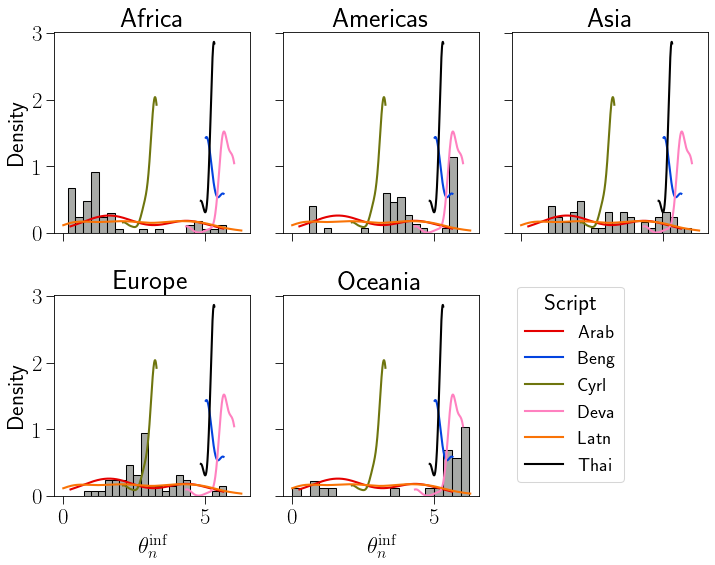

In [17]:
fig, axs = plt.subplots(2, 3, figsize=(10, 8), sharex=True, sharey=True)

colors = [
    "#e76254",
    "#ef8a47",
    "#f7aa58",
    "#ffd06f",
    "#ffe6b7",
    "#aadce0",
    "#72bcd5",
    "#528fad",
    "#376795",
    "#1e466e"
]
colors = [
  "xkcd:red", "xkcd:blue", "xkcd:olive", "xkcd:pink", "xkcd:orange", "xkcd:black"
]

axs = axs.flatten()

i = 0
for (name, group) in df_nodes_S1.groupby("region"):
    ax = axs[i]
    sns.histplot(group['inf_theta'], ax=ax, color='xkcd:grey', linewidth=1, fill=True, 
                 bins=20, stat='density', alpha=0.8)
    j = 0
    for (name2, group2) in df_features_S1.groupby("Scripts"):
        if len(group2) > 6:
            sns.kdeplot(group2['inf_theta'], ax=ax, color=colors[j], linewidth=2, label=name2, cut=0)
            #sns.histplot(group2['inf_theta'], ax=ax, color=colors[j], linewidth=2, label=name2, bins=20,
            #            stat='probability', element="step")
            j += 1

    ax.set_title(name)
    ax.set_xlabel(r'$\theta_n^{\mathrm{inf}}$')
    ax.set_ylabel('Density')
    i += 1

handles, labels = axs[-2].get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(0.7, 0.33), ncol=1, title='Script')

axs[-1].axis('off')

plt.tight_layout()


# plt.savefig("/home/rob/Dropbox/Robert/FeatureMercator/Reports/unicodelang-dataset-13-11-24/plots/unicodelang_S1_hist.pdf")


In [18]:
# df_nodes_S1[df_nodes_S1['region'] == 'Americas']

In [19]:
df_features_S1[df_features_S1['Language Type'] == 'es']

,index,inf_kappa,inf_theta,inf_radius,inf_kappa_le,inf_theta_le,inf_radius_le,Language Type,Language Name,Scripts
37,es,255.947,3.44907,12.2812,226.66,3.12845,11.138,es,Spanish,Latn


In [20]:
from networkx.algorithms import bipartite


g = bipartite.read_edgelist("/home/rob/MEGAsync/datasets/networks/bipartite_networks/unicodelang/country_lang_GCC.edge")
print(g)


Graph with 963 nodes and 1487 edges


In [21]:
df_features_S1.sort_values('inf_radius').head(20)

,index,inf_kappa,inf_theta,inf_radius,inf_kappa_le,inf_theta_le,inf_radius_le,Language Type,Language Name,Scripts
35,en,4842.5400,5.732580,6.40078,4500.7200,6.274420,5.16089,en,English,Latn
45,fr,785.6550,0.720511,10.03810,609.8440,0.972711,9.15847,fr,French,Latn
6,ar,259.3140,0.989777,12.25510,237.0680,1.042820,11.04820,ar,Arabic,Arab
37,es,255.9470,3.449070,12.28120,226.6600,3.128450,11.13800,es,Spanish,Latn
30,de,184.1930,2.498840,12.93920,128.5130,2.497500,12.27280,de,German,Latn
128,ru,151.8050,3.131750,13.32600,106.4830,2.883080,12.64890,ru,Russian,Cyrl
705,zh_Hant,83.1772,4.159720,14.52920,56.8607,3.408870,13.90370,zh_Hant,Chinese (Traditional),NaN
69,it,82.1113,2.670730,14.55500,56.8607,2.427400,13.90370,it,Italian,Latn
688,ff_Adlm,65.5135,0.151225,15.00670,41.5748,0.657237,14.52990,ff_Adlm,Fula (Adlam),NaN
41,ff,64.6612,0.165605,15.03290,41.5748,0.666000,14.52990,ff,Fula,Latn


In [22]:
from matplotlib.patches import Circle

def plot_language_graph(lang_name, lang_title, g, df_nodes_S1, df_features_S1, plot_max_speaker_population=0.001):

    pos_x, pos_y, countries, names, population = [], [], [], [], []
    speaker_population = []
    
    for country in list(g.neighbors(lang_name)):
        tmp = df_nodes_S1[df_nodes_S1['index'] == country]

        pos_x.append(tmp['inf_radius'] * np.cos(tmp['inf_theta']))
        pos_y.append(tmp['inf_radius'] * np.sin(tmp['inf_theta']))
        population.append(tmp['Population'])
        names.append(str(tmp['region'].values[0]))
        countries.append(tmp['Name'].values[0].replace('&', r'\&'))
        
        # Print country details (optional)
        print(tmp['Name'].values[0], " ", tmp['region'].values[0], " ", tmp['sub-region'].values[0], " ", tmp['Population'].values[0])
        
        speakers = eval(tmp['Languages'].values.tolist()[0])
        speakers_dict = {l: p for l, p in speakers}
    
        speaker_population.append(speakers_dict[lang_name] * tmp['Population'] / 100)
        
    population = np.array(population)
    speaker_population= np.array(speaker_population)

    colors = [
        "#e76254", "#ef8a47", "#f7aa58", "#ffd06f", "#ffe6b7",
        "#aadce0", "#72bcd5", "#528fad", "#376795", "#1e466e"
    ][::2]

    color_mapping = {n: c for n, c in zip(np.unique(df_nodes_S1['region'].astype(str)), colors)}
    colors = [color_mapping[name] for name in names]

    fig, axs = plt.subplots(figsize=(7, 7))
    
    speaker_population /= max(speaker_population)
    lower_threshold = np.percentile(speaker_population[speaker_population > 0], 10)
    speaker_population = np.where(speaker_population < lower_threshold, lower_threshold, speaker_population)
    
    #600 * population / max(population)
    axs.scatter(pos_x, pos_y, c=colors, s=500*speaker_population,
                edgecolors='black', alpha=0.7, linewidths=0.5, zorder=1)

    for (x, y, c, p) in zip(pos_x, pos_y, countries, speaker_population):
        if p > plot_max_speaker_population:
            axs.text(x, y, c, zorder=100)

    lang = df_features_S1[df_features_S1['index'] == lang_name]
    axs.scatter(lang['inf_radius'] * np.cos(lang['inf_theta']),
                lang['inf_radius'] * np.sin(lang['inf_theta']),
                s=500, color='xkcd:grey', marker='*', edgecolors='black', zorder=10)
    
    axs.text(lang['inf_radius'] * np.cos(lang['inf_theta']),
             lang['inf_radius'] * np.sin(lang['inf_theta']), lang_title,
             color='xkcd:black', bbox=dict(facecolor='none', edgecolor='black', boxstyle='round'),
             zorder=10)
    
    circle = Circle((0, 0), df_nodes_S1['inf_radius'].max(), color='black', fill=False, linestyle='-', linewidth=1)
    axs.add_patch(circle)

    legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_mapping[region], markersize=10)
                      for region in color_mapping]
    legend_labels = list(color_mapping.keys())
    axs.legend(legend_handles, legend_labels, loc=(1, 0.1), framealpha=1)

    axs.axis('off')
    #axs.set_title(lang_title)
    axs.set_box_aspect(1)
    plt.tight_layout()


Canada   Americas   Northern America   38794800
Fiji   Oceania   Melanesia   951611
India   Asia   Southern Asia   1409130000
Nepal   Asia   Southern Asia   31122400
Uganda   Africa   Sub-Saharan Africa   49283000
South Africa   Africa   Sub-Saharan Africa   60442600


/home/rob/.local/lib/python3.10/site-packages/matplotlib/cbook.py:1709: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)
/home/rob/.local/lib/python3.10/site-packages/matplotlib/text.py:905: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  x = float(self.convert_xunits(self._x))
/home/rob/.local/lib/python3.10/site-packages/matplotlib/text.py:906: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(self._y))
/home/rob/.local/lib/python3.10/site-packages/matplotlib/text.py:762: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posx = float(self.convert_xunits

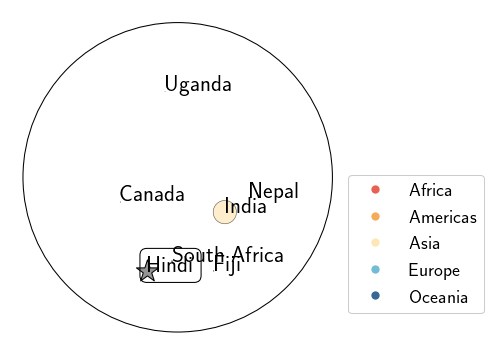

In [23]:
lang_name = 'hi'
lang_title = 'Hindi'
plot_language_graph(lang_name, lang_title, g, df_nodes_S1, df_features_S1, plot_max_speaker_population=0.0001)

# plt.savefig("/home/rob/Dropbox/Robert/FeatureMercator/Paper/plots/unicodelang/S1_lang_hindi.pdf")

Burundi   Africa   Sub-Saharan Africa   13590100
Congo - Kinshasa   Africa   Sub-Saharan Africa   115403000
Kenya   Africa   Sub-Saharan Africa   58246400
Mozambique   Africa   Sub-Saharan Africa   33351000
Somalia   Africa   Sub-Saharan Africa   13017300
Tanzania   Africa   Sub-Saharan Africa   67462100
Uganda   Africa   Sub-Saharan Africa   49283000
Mayotte   Africa   Sub-Saharan Africa   194000
South Africa   Africa   Sub-Saharan Africa   60442600


/home/rob/.local/lib/python3.10/site-packages/matplotlib/cbook.py:1709: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)
/home/rob/.local/lib/python3.10/site-packages/matplotlib/text.py:905: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  x = float(self.convert_xunits(self._x))
/home/rob/.local/lib/python3.10/site-packages/matplotlib/text.py:906: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(self._y))
/home/rob/.local/lib/python3.10/site-packages/matplotlib/text.py:762: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posx = float(self.convert_xunits

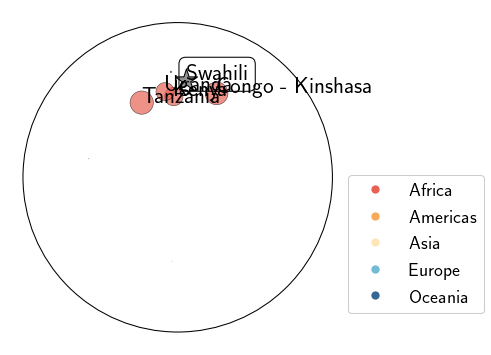

In [24]:
lang_name = 'sw'
lang_title = 'Swahili'
plot_language_graph(lang_name, lang_title, g, df_nodes_S1, df_features_S1, plot_max_speaker_population=0.005)

# plt.savefig("/home/rob/Dropbox/Robert/FeatureMercator/Paper/plots/unicodelang/S1_lang_swahili.pdf")

Andorra   Europe   Southern Europe   85370
Spain   Europe   Southern Europe   47280400
France   Europe   Western Europe   68374600
Italy   Europe   Southern Europe   60964900


/home/rob/.local/lib/python3.10/site-packages/matplotlib/cbook.py:1709: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)
/home/rob/.local/lib/python3.10/site-packages/matplotlib/text.py:905: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  x = float(self.convert_xunits(self._x))
/home/rob/.local/lib/python3.10/site-packages/matplotlib/text.py:906: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(self._y))
/home/rob/.local/lib/python3.10/site-packages/matplotlib/text.py:762: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posx = float(self.convert_xunits

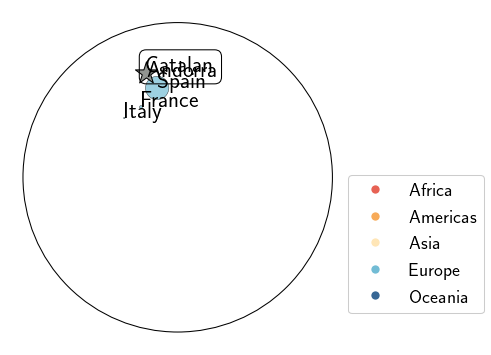

In [25]:
lang_name = 'ca'
lang_title = 'Catalan'
plot_language_graph(lang_name, lang_title, g, df_nodes_S1, df_features_S1, plot_max_speaker_population=0.001)

# plt.savefig("/home/rob/Dropbox/Robert/FeatureMercator/Paper/plots/unicodelang/S1_lang_catalan.pdf")

United Arab Emirates   Asia   Western Asia   10032200
Antigua & Barbuda   Americas   Latin America and the Caribbean   102634
Anguilla   Americas   Latin America and the Caribbean   19416
Argentina   Americas   Latin America and the Caribbean   46994400
American Samoa   Oceania   Polynesia   43895
Austria   Europe   Western Europe   8967980
Australia   Oceania   Australia and New Zealand   26768600
Aruba   Americas   Latin America and the Caribbean   125063
Bosnia & Herzegovina   Europe   Southern Europe   3798670
Barbados   Americas   Latin America and the Caribbean   304139
Bangladesh   Asia   Southern Asia   168697000
Belgium   Europe   Western Europe   11977600
Bulgaria   Europe   Eastern Europe   6782660
Burundi   Africa   Sub-Saharan Africa   13590100
Bermuda   Americas   Northern America   72800
Brunei   Asia   South-eastern Asia   491900
Brazil   Americas   Latin America and the Caribbean   220052000
Bahamas   Americas   Latin America and the Caribbean   410862
Bhutan   Asia   

/home/rob/.local/lib/python3.10/site-packages/matplotlib/cbook.py:1709: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)
/home/rob/.local/lib/python3.10/site-packages/matplotlib/text.py:905: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  x = float(self.convert_xunits(self._x))
/home/rob/.local/lib/python3.10/site-packages/matplotlib/text.py:906: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(self._y))
/home/rob/.local/lib/python3.10/site-packages/matplotlib/text.py:762: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posx = float(self.convert_xunits

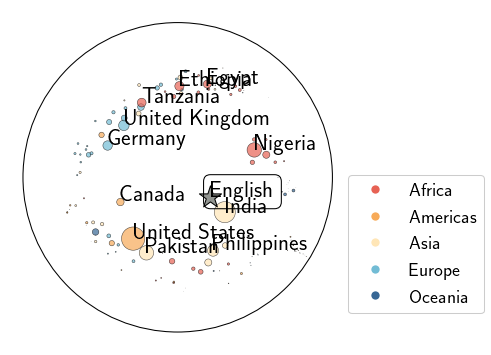

In [26]:
lang_name = 'en'
lang_title = 'English'
plot_language_graph(lang_name, lang_title, g, df_nodes_S1, df_features_S1, plot_max_speaker_population=0.1)

# plt.savefig("/home/rob/Dropbox/Robert/FeatureMercator/Paper/plots/unicodelang/S1_lang_english.pdf")

Andorra   Europe   Southern Europe   85370
Argentina   Americas   Latin America and the Caribbean   46994400
Bolivia   Americas   Latin America and the Caribbean   12312000
Brazil   Americas   Latin America and the Caribbean   220052000
Belize   Americas   Latin America and the Caribbean   415789
Canada   Americas   Northern America   38794800
Chile   Americas   Latin America and the Caribbean   18664700
Colombia   Americas   Latin America and the Caribbean   49588400
Costa Rica   Americas   Latin America and the Caribbean   5265580
Cuba   Americas   Latin America and the Caribbean   10966000
Curaçao   Americas   Latin America and the Caribbean   153289
Germany   Europe   Western Europe   84119100
Dominican Republic   Americas   Latin America and the Caribbean   10815900
Ecuador   Americas   Latin America and the Caribbean   18310000
Spain   Europe   Southern Europe   47280400
France   Europe   Western Europe   68374600
United Kingdom   Europe   Northern Europe   68459100
Gibraltar   E

/home/rob/.local/lib/python3.10/site-packages/matplotlib/cbook.py:1709: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)
/home/rob/.local/lib/python3.10/site-packages/matplotlib/text.py:905: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  x = float(self.convert_xunits(self._x))
/home/rob/.local/lib/python3.10/site-packages/matplotlib/text.py:906: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(self._y))
/home/rob/.local/lib/python3.10/site-packages/matplotlib/text.py:762: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posx = float(self.convert_xunits

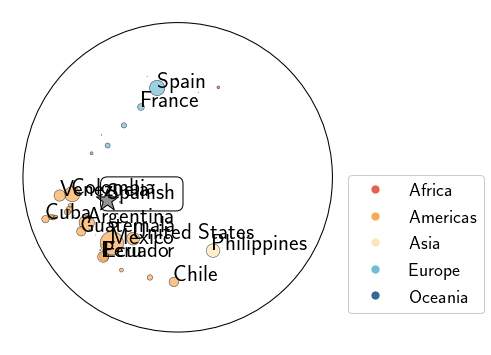

In [27]:
lang_name = 'es'
lang_title = 'Spanish'
plot_language_graph(lang_name, lang_title, g, df_nodes_S1, df_features_S1, plot_max_speaker_population=0.08)

# plt.savefig("/home/rob/Dropbox/Robert/FeatureMercator/Paper/plots/unicodelang/S1_lang_spanish.pdf")

Andorra   Europe   Southern Europe   85370
Austria   Europe   Western Europe   8967980
Belgium   Europe   Western Europe   11977600
Burkina Faso   Africa   Sub-Saharan Africa   23042200
Burundi   Africa   Sub-Saharan Africa   13590100
Benin   Africa   Sub-Saharan Africa   14697100
St. Barthélemy   Americas   Latin America and the Caribbean   7086
Canada   Americas   Northern America   38794800
Congo - Kinshasa   Africa   Sub-Saharan Africa   115403000
Central African Republic   Africa   Sub-Saharan Africa   5650960
Congo - Brazzaville   Africa   Sub-Saharan Africa   6097670
Switzerland   Europe   Western Europe   8860570
Côte d’Ivoire   Africa   Sub-Saharan Africa   29981800
Cameroon   Africa   Sub-Saharan Africa   30966100
Cyprus   Asia   Western Asia   1320530
Germany   Europe   Western Europe   84119100
Djibouti   Africa   Sub-Saharan Africa   994974
Algeria   Africa   Northern Africa   47022500
France   Europe   Western Europe   68374600
Gabon   Africa   Sub-Saharan Africa   245511

/home/rob/.local/lib/python3.10/site-packages/matplotlib/cbook.py:1709: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)
/home/rob/.local/lib/python3.10/site-packages/matplotlib/text.py:905: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  x = float(self.convert_xunits(self._x))
/home/rob/.local/lib/python3.10/site-packages/matplotlib/text.py:906: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(self._y))
/home/rob/.local/lib/python3.10/site-packages/matplotlib/text.py:762: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posx = float(self.convert_xunits

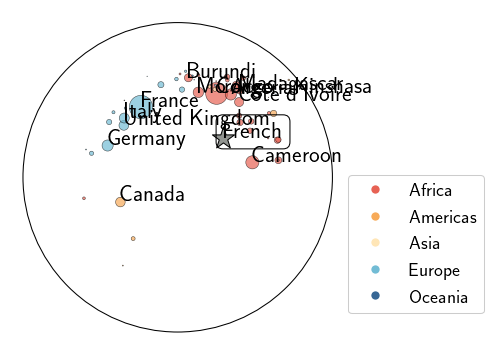

In [28]:
lang_name = 'fr'
lang_title = 'French'
plot_language_graph(lang_name, lang_title, g, df_nodes_S1, df_features_S1, plot_max_speaker_population=0.1)

# plt.savefig("/home/rob/Dropbox/Robert/FeatureMercator/Paper/plots/unicodelang/S1_lang_french.pdf")

United Arab Emirates   Asia   Western Asia   10032200
Afghanistan   Asia   Southern Asia   40121600
Canada   Americas   Northern America   38794800
Iraq   Asia   Western Asia   42083400
Iran   Asia   Southern Asia   88386900
Oman   Asia   Western Asia   3901990
Pakistan   Asia   Southern Asia   252364000
Qatar   Asia   Western Asia   2552090
Tajikistan   Asia   Central Asia   10394100


/home/rob/.local/lib/python3.10/site-packages/matplotlib/cbook.py:1709: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)
/home/rob/.local/lib/python3.10/site-packages/matplotlib/text.py:905: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  x = float(self.convert_xunits(self._x))
/home/rob/.local/lib/python3.10/site-packages/matplotlib/text.py:906: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(self._y))
/home/rob/.local/lib/python3.10/site-packages/matplotlib/text.py:762: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posx = float(self.convert_xunits

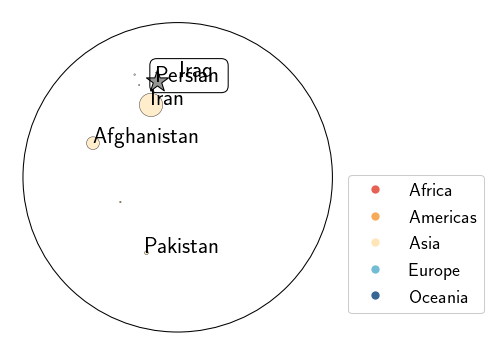

In [29]:
lang_name = 'fa'
lang_title = 'Persian'
plot_language_graph(lang_name, lang_title, g, df_nodes_S1, df_features_S1, plot_max_speaker_population=0.005)

# plt.savefig("/home/rob/Dropbox/Robert/FeatureMercator/Paper/plots/unicodelang/S1_lang_persian.pdf")

Brazil   Americas   Latin America and the Caribbean   220052000
Canada   Americas   Northern America   38794800
China   Asia   Eastern Asia   1416040000
Japan   Asia   Eastern Asia   123202000
North Korea   Asia   Eastern Asia   26298700
South Korea   Asia   Eastern Asia   52081800
United States   Americas   Northern America   341963000


/home/rob/.local/lib/python3.10/site-packages/matplotlib/cbook.py:1709: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)
/home/rob/.local/lib/python3.10/site-packages/matplotlib/text.py:905: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  x = float(self.convert_xunits(self._x))
/home/rob/.local/lib/python3.10/site-packages/matplotlib/text.py:906: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(self._y))
/home/rob/.local/lib/python3.10/site-packages/matplotlib/text.py:762: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posx = float(self.convert_xunits

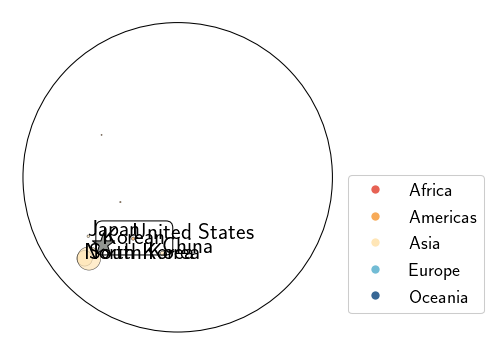

In [30]:
lang_name = 'ko'
lang_title = 'Korean'
plot_language_graph(lang_name, lang_title, g, df_nodes_S1, df_features_S1, plot_max_speaker_population=0.01)

# plt.savefig("/home/rob/Dropbox/Robert/FeatureMercator/Paper/plots/unicodelang/S1_lang_korean.pdf")

Aruba   Americas   Latin America and the Caribbean   125063
Belgium   Europe   Western Europe   11977600
Caribbean Netherlands   Americas   Latin America and the Caribbean   20000
Canada   Americas   Northern America   38794800
Curaçao   Americas   Latin America and the Caribbean   153289
Germany   Europe   Western Europe   84119100
France   Europe   Western Europe   68374600
Netherlands   Europe   Western Europe   17772400
Suriname   Americas   Latin America and the Caribbean   646758
Sint Maarten   Americas   Latin America and the Caribbean   46215


/home/rob/.local/lib/python3.10/site-packages/matplotlib/cbook.py:1709: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)
/home/rob/.local/lib/python3.10/site-packages/matplotlib/text.py:905: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  x = float(self.convert_xunits(self._x))
/home/rob/.local/lib/python3.10/site-packages/matplotlib/text.py:906: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(self._y))
/home/rob/.local/lib/python3.10/site-packages/matplotlib/text.py:762: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posx = float(self.convert_xunits

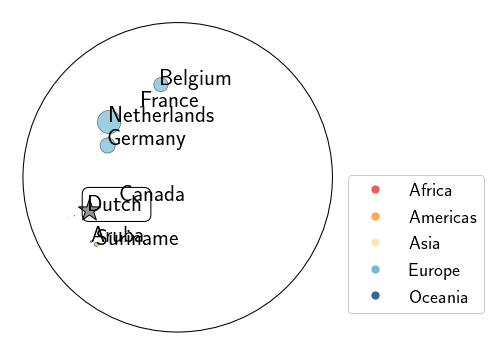

In [31]:
lang_name = 'nl'
lang_title = 'Dutch'
plot_language_graph(lang_name, lang_title, g, df_nodes_S1, df_features_S1, plot_max_speaker_population=0.001)

# plt.savefig("/home/rob/Dropbox/Robert/FeatureMercator/Paper/plots/unicodelang/S1_lang_dutch.pdf")

United Arab Emirates   Asia   Western Asia   10032200
Bahrain   Asia   Western Asia   1566890
Canada   Americas   Northern America   38794800
Cameroon   Africa   Sub-Saharan Africa   30966100
Cyprus   Asia   Western Asia   1320530
Djibouti   Africa   Sub-Saharan Africa   994974
Algeria   Africa   Northern Africa   47022500
Egypt   Africa   Northern Africa   111247000
Western Sahara   Africa   Northern Africa   652271
Eritrea   Africa   Sub-Saharan Africa   6343960
United Kingdom   Europe   Northern Europe   68459100
Israel   Asia   Western Asia   9402620
Iraq   Asia   Western Asia   42083400
Iran   Asia   Southern Asia   88386900
Jordan   Asia   Western Asia   11174000
Kenya   Africa   Sub-Saharan Africa   58246400
Comoros   Africa   Sub-Saharan Africa   900141
Kuwait   Asia   Western Asia   3138360
Lebanon   Asia   Western Asia   5364480
Libya   Africa   Northern Africa   7361260
Morocco   Africa   Northern Africa   37387600
Mali   Africa   Sub-Saharan Africa   21990600
Mauritania   A

/home/rob/.local/lib/python3.10/site-packages/matplotlib/cbook.py:1709: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)
/home/rob/.local/lib/python3.10/site-packages/matplotlib/text.py:905: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  x = float(self.convert_xunits(self._x))
/home/rob/.local/lib/python3.10/site-packages/matplotlib/text.py:906: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(self._y))
/home/rob/.local/lib/python3.10/site-packages/matplotlib/text.py:762: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posx = float(self.convert_xunits

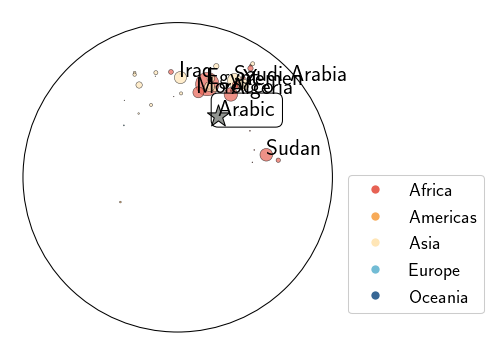

In [32]:
lang_name = 'ar'
lang_title = 'Arabic'
plot_language_graph(lang_name, lang_title, g, df_nodes_S1, df_features_S1, plot_max_speaker_population=0.2)

# plt.savefig("/home/rob/Dropbox/Robert/FeatureMercator/Paper/plots/unicodelang/S1_lang_arabic.pdf")

Bulgaria   Europe   Eastern Europe   6782660
Belarus   Europe   Eastern Europe   9501450
Canada   Americas   Northern America   38794800
China   Asia   Eastern Asia   1416040000
Germany   Europe   Western Europe   84119100
Estonia   Europe   Northern Europe   1193790
Finland   Europe   Northern Europe   5626410
Georgia   Asia   Western Asia   4900960
Israel   Asia   Western Asia   9402620
Kyrgyzstan   Asia   Central Asia   6172100
Kazakhstan   Asia   Central Asia   20260000
Lithuania   Europe   Northern Europe   2628190
Latvia   Europe   Northern Europe   1801250
Moldova   Europe   Eastern Europe   3599530
Mongolia   Asia   Eastern Asia   3281680
Poland   Europe   Eastern Europe   38746300
Russia   Europe   Eastern Europe   140821000
Svalbard & Jan Mayen   Europe   Northern Europe   2926
Tajikistan   Asia   Central Asia   10394100
Turkmenistan   Asia   Central Asia   5744150
Ukraine   Europe   Eastern Europe   35661800
United States   Americas   Northern America   341963000
Uzbekistan 

/home/rob/.local/lib/python3.10/site-packages/matplotlib/cbook.py:1709: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)
/home/rob/.local/lib/python3.10/site-packages/matplotlib/text.py:905: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  x = float(self.convert_xunits(self._x))
/home/rob/.local/lib/python3.10/site-packages/matplotlib/text.py:906: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(self._y))
/home/rob/.local/lib/python3.10/site-packages/matplotlib/text.py:762: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posx = float(self.convert_xunits

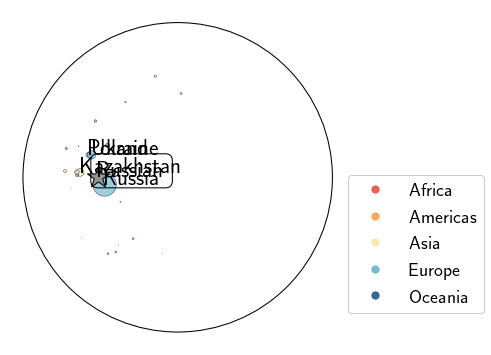

In [33]:
lang_name = 'ru'
lang_title = 'Russian'
plot_language_graph(lang_name, lang_title, g, df_nodes_S1, df_features_S1, plot_max_speaker_population=0.05)

# plt.savefig("/home/rob/Dropbox/Robert/FeatureMercator/Paper/plots/unicodelang/S1_lang_russian.pdf")

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

def plot_languages_for_country(country_name, country_title, g, df_nodes_S1, df_features_S1, percent_speakers_show=0.05):
    pos_x, pos_y, languages, scripts, lang_degree = [], [], [], [], []
    short_lang_name = []
    
    top_scripts = df_features_S1.groupby('Scripts').size().nlargest(5).index
    
    for language in list(g.neighbors(country_name)):
        tmp = df_features_S1[df_features_S1['index'] == language]
        
        if len(tmp) < 1:
            continue

        pos_x.append(tmp['inf_radius'].values[0] * np.cos(tmp['inf_theta'].values[0]))
        pos_y.append(tmp['inf_radius'].values[0] * np.sin(tmp['inf_theta'].values[0]))
        languages.append(tmp['Language Name'].values[0].replace('&', r'\&'))
        lang_degree.append(g.degree(language))
        script = tmp['Scripts'].values[0] if pd.notna(tmp['Scripts'].values[0]) else 'Other'
        scripts.append(script)
        
        print(language, " ", tmp['Language Name'].values[0], " ", tmp['Scripts'].values[0])
        
        short_lang_name.append(tmp['index'].values[0])
    
    colors = [
        "#e76254", "#ef8a47", "#f7aa58", "#ffd06f", "#ffe6b7",
        "#aadce0", "#72bcd5", "#528fad", "#376795", "#1e466e"
    ][::2]
    colors =[
      "#d7aca1",
      "#ddc000",
      "#79ad41",
      "#34b6c6",
      "#4063a3"
    ]
    grey_color = "xkcd:light grey"
    
    # scale by the speakers in that country
    country = df_nodes_S1[df_nodes_S1['index'] == country_name]
    
    speakers = eval(country['Languages'].values.tolist()[0])
    speakers_dict = {l: p for l, p in speakers}
    country_population = country['Population'].values[0]
    
    lang_sizes = []
    for s in short_lang_name:
        lang_sizes.append(speakers_dict[s] * country_population / 100)
    lang_sizes = np.array(lang_sizes)
    
    color_mapping = {script: color for script, color in zip(top_scripts, colors)}
    color_mapping['Other'] = grey_color
    colors = [color_mapping.get(script, grey_color) for script in scripts]

    fig, axs = plt.subplots(figsize=(7, 7))

    lang_sizes /= max(lang_sizes)
    lower_threshold = np.percentile(lang_sizes[lang_sizes > 0], 10)
    lang_sizes = np.where(lang_sizes < lower_threshold, lower_threshold, lang_sizes)
       
    axs.scatter(pos_x, pos_y, c=colors, s=2000*lang_sizes,
                edgecolors='black', alpha=0.7, linewidths=0.5, zorder=1)

    for (x, y, lang, deg) in zip(pos_x, pos_y, languages, lang_sizes):
        if deg > percent_speakers_show:
            axs.text(x, y, lang, zorder=10)

    
    axs.scatter(country['inf_radius'] * np.cos(country['inf_theta']),
                country['inf_radius'] * np.sin(country['inf_theta']),
                s=500, color='xkcd:dark grey', marker='X', edgecolors='black', zorder=2)
    axs.text(country['inf_radius'] * np.cos(country['inf_theta']),
             country['inf_radius'] * np.sin(country['inf_theta']), country_title,
             color='xkcd:black', bbox=dict(facecolor='none', edgecolor='black', boxstyle='round'),
             zorder=10)
    
    circle = Circle((0, 0), df_features_S1['inf_radius'].max(), color='black', fill=False, linestyle='-', linewidth=1)
    axs.add_patch(circle)

    legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_mapping[script], markersize=10)
                      for script in color_mapping]
    legend_labels = list(color_mapping.keys())
    axs.legend(legend_handles, legend_labels, loc=(1, 0.1), framealpha=1)

    axs.axis('off')
    #axs.set_title(country_title)
    axs.set_box_aspect(1)
    plt.tight_layout()

en   English   Latn
ug   Uyghur   Arab Cyrl
kk_Arab   Kazakh (Arabic)   nan
hnj   Hmong Njua   Laoo
ru   Russian   Cyrl
ko   Korean   Kore
zh   Chinese   Hans Hant
yue   Cantonese   Hans Hant
vi   Vietnamese   Latn
wuu   Wu Chinese   Hans
yue_Hans   Cantonese (Simplified)   nan
hsn   Xiang Chinese   Hans
hak   Hakka Chinese   Hans Hant
gan   Gan Chinese   Hans
ii   Sichuan Yi   Yiii
za   Zhuang   Latn
mn_Mong   Mongolian (Mongolian)   nan
bo   Tibetan   Tibt
lis   Lisu   Lisu
ky_Arab   Kyrgyz (Arabic)   nan
nxq   Naxi   Latn
khb   Lü   Talu
tdd   Tai Nüa   Tale
lcp   Western Lawa   Thai
uz_Cyrl   Uzbek (Cyrillic)   nan
lzh   Literary Chinese   Hans


/home/rob/.local/lib/python3.10/site-packages/matplotlib/text.py:905: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  x = float(self.convert_xunits(self._x))
/home/rob/.local/lib/python3.10/site-packages/matplotlib/text.py:906: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(self._y))
/home/rob/.local/lib/python3.10/site-packages/matplotlib/text.py:762: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posx = float(self.convert_xunits(x))
/home/rob/.local/lib/python3.10/site-packages/matplotlib/text.py:763: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posy = float(self.conve

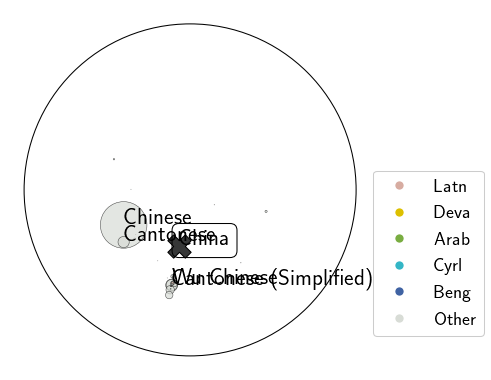

In [35]:
plot_languages_for_country('CN', 'China', g, df_nodes_S1, df_features_S1)

# plt.savefig("/home/rob/Dropbox/Robert/FeatureMercator/Paper/plots/unicodelang/S1_country_china.pdf")

en   English   Latn
ml   Malayalam   Mlym
bn   Bangla   Beng
rkt   Rangpuri   Beng
ccp   Chakma   Beng Cakm
grt   Garo   Beng
mni   Manipuri   Beng
dz   Dzongkha   Tibt
ne   Nepali   Deva
lep   Lepcha   Lepc
pa   Punjabi   Arab Guru
ur   Urdu   Arab
hi   Hindi   Deva
ta   Tamil   Taml
gu   Gujarati   Gujr
bo   Tibetan   Tibt
te   Telugu   Telu
mr   Marathi   Deva
kn   Kannada   Knda
or   Odia   Orya
bho   Bhojpuri   Deva
awa   Awadhi   Deva
as   Assamese   Beng
bgc   Haryanvi   Deva
mag   Magahi   Deva
mwr   Marwari   Deva
mai   Maithili   Deva
hne   Chhattisgarhi   Deva
dcc   Deccan   Arab
bjj   Kanauji   Deva
sat   Santali   Olck
wtm   Mewati   Deva
ks   Kashmiri   Arab Deva
knn   Konkani [individual language]   Deva
kok   Konkani   Deva Latn
swv   Shekhawati   Deva
gbm   Garhwali   Deva
lmn   Lambadi   Telu
sd   Sindhi   Arab Deva
gon   Gondi   Deva Telu
kfy   Kumaoni   Deva
doi   Dogri   Deva
kru   Kurukh   Deva
sck   Sadri   Deva
wbq   Waddar   Telu
xnr   Kangri   Deva
tcy   Tulu 

/home/rob/.local/lib/python3.10/site-packages/matplotlib/text.py:905: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  x = float(self.convert_xunits(self._x))
/home/rob/.local/lib/python3.10/site-packages/matplotlib/text.py:906: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(self._y))
/home/rob/.local/lib/python3.10/site-packages/matplotlib/text.py:762: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posx = float(self.convert_xunits(x))
/home/rob/.local/lib/python3.10/site-packages/matplotlib/text.py:763: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posy = float(self.conve

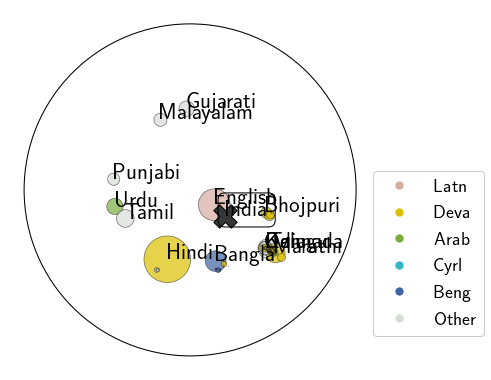

In [36]:
plot_languages_for_country('IN', 'India', g, df_nodes_S1, df_features_S1)

# plt.savefig("/home/rob/Dropbox/Robert/FeatureMercator/Paper/plots/unicodelang/S1_country_india.pdf")

es   Spanish   Latn
en   English   Latn
pt   Portuguese   Latn
de   German   Latn
it   Italian   Latn
vec   Venetian   Latn
ja   Japanese   Jpan
kgp   Kaingang   Latn
ko   Korean   Kore
yrl   Nheengatu   Latn
gub   Guajajára   Latn
xav   Xavánte   Latn


/home/rob/.local/lib/python3.10/site-packages/matplotlib/text.py:905: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  x = float(self.convert_xunits(self._x))
/home/rob/.local/lib/python3.10/site-packages/matplotlib/text.py:906: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(self._y))
/home/rob/.local/lib/python3.10/site-packages/matplotlib/text.py:762: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posx = float(self.convert_xunits(x))
/home/rob/.local/lib/python3.10/site-packages/matplotlib/text.py:763: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posy = float(self.conve

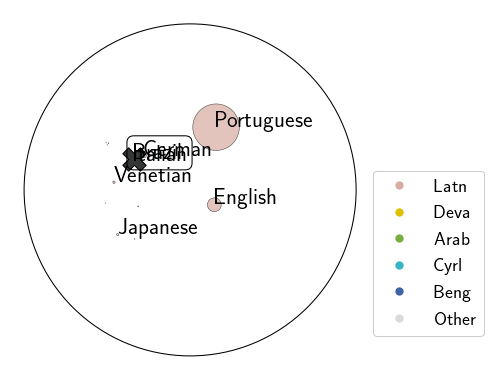

In [37]:
plot_languages_for_country('BR', 'Brazil', g, df_nodes_S1, df_features_S1, percent_speakers_show=0.001)

# plt.savefig("/home/rob/Dropbox/Robert/FeatureMercator/Paper/plots/unicodelang/S1_country_brazil.pdf")

es   Spanish   Latn
fr   French   Latn
ar   Arabic   Arab
en   English   Latn
fa   Persian   Arab
pt   Portuguese   Latn
el   Greek   Grek
de   German   Latn
it   Italian   Latn
hr   Croatian   Latn
hu   Hungarian   Latn
nl   Dutch   Latn
sr   Serbian   Cyrl Latn
bn   Bangla   Beng
ru   Russian   Cyrl
tr   Turkish   Latn
ja   Japanese   Jpan
ko   Korean   Kore
zh   Chinese   Hans Hant
yue   Cantonese   Hans Hant
pa   Punjabi   Arab Guru
fil   Filipino   Latn
ur   Urdu   Arab
hi   Hindi   Deva
ta   Tamil   Taml
vi   Vietnamese   Latn
pl   Polish   Latn
gu   Gujarati   Gujr
ro   Romanian   Latn
pdt   Plautdietsch   Latn
uk   Ukrainian   Cyrl
so   Somali   Latn
iu   Inuktitut   Cans Latn
iu_Latn   Inuktitut (Latin)   nan
oj   Ojibwa   Cans
ojs   Oji-Cree   Cans
chp   Chipewyan   Latn
moe   Innu-aimun   Latn
cr   Cree   Cans Latn
mic   Mi'kmaw   Latn
atj   Atikamekw   Latn
bla   Siksiká   Latn
crk   Plains Cree   Cans
den   Slave   Latn
dgr   Dogrib   Latn
csw   Swampy Cree   Cans
moh   Mo

/home/rob/.local/lib/python3.10/site-packages/matplotlib/text.py:905: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  x = float(self.convert_xunits(self._x))
/home/rob/.local/lib/python3.10/site-packages/matplotlib/text.py:906: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(self._y))
/home/rob/.local/lib/python3.10/site-packages/matplotlib/text.py:762: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posx = float(self.convert_xunits(x))
/home/rob/.local/lib/python3.10/site-packages/matplotlib/text.py:763: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posy = float(self.conve

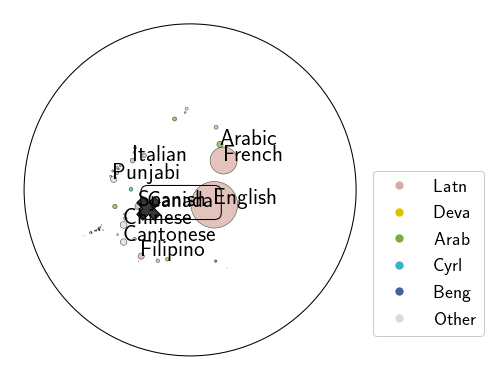

In [38]:
plot_languages_for_country('CA', 'Canada', g, df_nodes_S1, df_features_S1, percent_speakers_show=0.01)

# plt.savefig("/home/rob/Dropbox/Robert/FeatureMercator/Paper/plots/unicodelang/S1_country_canada.pdf")

ar   Arabic   Arab
en   English   Latn
kaa   Kara-Kalpak   Cyrl Latn
sq   Albanian   Latn
el   Greek   Grek
hy   Armenian   Armn
ku   Kurdish   Arab Cyrl Latn
az   Azerbaijani   Arab Cyrl Latn
sr_Latn   Serbian (Latin)   nan
bg   Bulgarian   Cyrl
tr   Turkish   Latn
ka   Georgian   Geor
ab   Abkhazian   Cyrl
apc   Levantine Arabic   nan
az_Arab   Azerbaijani (Arabic)   nan
kk   Kazakh   Arab Cyrl
kbd   Kabardian   Cyrl
ady   Adyghe   Cyrl
uz   Uzbek   Arab Cyrl Latn
zza   Zaza   Latn
bgx   Balkan Gagauz Turkish   Grek
kiu   Kirmanjki   Latn
lzz   Laz   Latn
pnt_Latn   Pontic (Latin)   nan
tru   Turoyo   Latn
ky_Latn   Kyrgyz (Latin)   nan


/home/rob/.local/lib/python3.10/site-packages/matplotlib/text.py:905: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  x = float(self.convert_xunits(self._x))
/home/rob/.local/lib/python3.10/site-packages/matplotlib/text.py:906: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(self._y))
/home/rob/.local/lib/python3.10/site-packages/matplotlib/text.py:762: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posx = float(self.convert_xunits(x))
/home/rob/.local/lib/python3.10/site-packages/matplotlib/text.py:763: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posy = float(self.conve

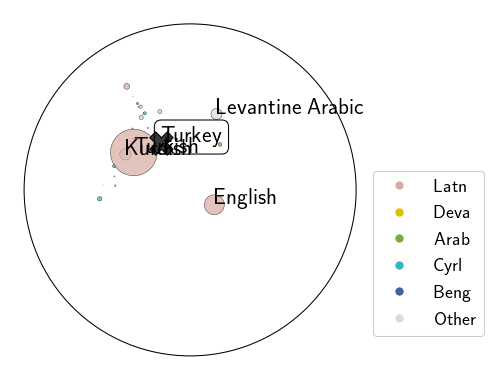

In [39]:
plot_languages_for_country('TR', 'Turkey', g, df_nodes_S1, df_features_S1, percent_speakers_show=0.05)

# plt.savefig("/home/rob/Dropbox/Robert/FeatureMercator/Paper/plots/unicodelang/S1_country_turkey.pdf")

zh_Hant   Chinese (Traditional)   nan
ms   Malay   Arab Latn
ms_Arab   Malay (Arabic)   nan
id   Indonesian   Latn
jv   Javanese   Latn
su   Sundanese   Latn
mad   Madurese   Latn
min   Minangkabau   Latn
bew   Betawi   Latn
ban   Balinese   Latn
bug   Buginese   Latn
bjn   Banjar   Latn
ace   Acehnese   Latn
sas   Sasak   Latn
bbc   Batak Toba   Latn
mak   Makasar   Latn
ljp   Lampung Api   Latn
rej   Rejang   Latn
gor   Gorontalo   Latn
nij   Ngaju   Latn
kge   Komering   Latn
aoz   Uab Meto   Latn
kvr   Kerinci   Latn
lbw   Tolaki   Latn
gay   Gayo   Latn
rob   Tae'   Latn
mdr   Mandar   Latn
sxn   Sangir   Latn
sly   Selayar   Latn
mwv   Mentawai   Latn


/home/rob/.local/lib/python3.10/site-packages/matplotlib/text.py:905: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  x = float(self.convert_xunits(self._x))
/home/rob/.local/lib/python3.10/site-packages/matplotlib/text.py:906: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(self._y))
/home/rob/.local/lib/python3.10/site-packages/matplotlib/text.py:762: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posx = float(self.convert_xunits(x))
/home/rob/.local/lib/python3.10/site-packages/matplotlib/text.py:763: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posy = float(self.conve

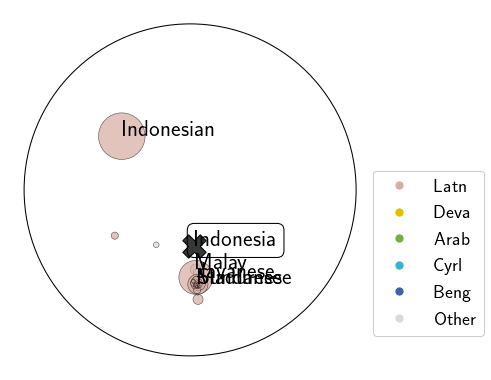

In [40]:
plot_languages_for_country('ID', 'Indonesia', g, df_nodes_S1, df_features_S1, percent_speakers_show=0.05)

# plt.savefig("/home/rob/Dropbox/Robert/FeatureMercator/Paper/plots/unicodelang/S1_country_indonesia.pdf")

fr   French   Latn
ar   Arabic   Arab
en   English   Latn
ff   Fula   Latn
ff_Adlm   Fula (Adlam)   nan
bum   Bulu   Latn
ewo   Ewondo   Latn
ybb   Yemba   Latn
bbj   Ghomala   Latn
nnh   Ngiemboon   Latn
bkm   Kom   Latn
bas   Basaa   Latn
bax   Bamun   Bamu
byv   Medumba   Latn
mua   Mundang   Latn
maf   Mafa   Latn
bfd   Bafut   Latn
bss   Akoose   Latn
kkj   Kako   Latn
dua   Duala   Latn
mgo   Metaʼ   Latn
jgo   Ngomba   Latn
ksf   Bafia   Latn
ken   Kenyang   nan
agq   Aghem   Latn
ha_Arab   Hausa (Arabic)   nan
nmg   Kwasio   Latn
yav   Yangben   Latn


/home/rob/.local/lib/python3.10/site-packages/matplotlib/text.py:905: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  x = float(self.convert_xunits(self._x))
/home/rob/.local/lib/python3.10/site-packages/matplotlib/text.py:906: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(self._y))
/home/rob/.local/lib/python3.10/site-packages/matplotlib/text.py:762: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posx = float(self.convert_xunits(x))
/home/rob/.local/lib/python3.10/site-packages/matplotlib/text.py:763: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posy = float(self.conve

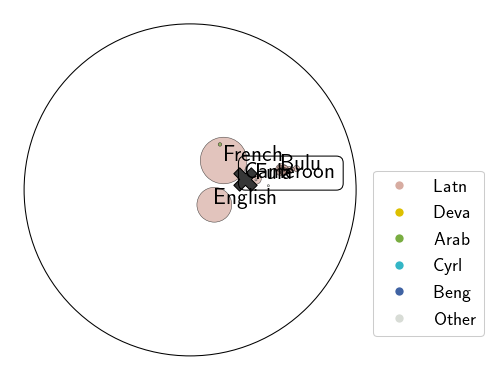

In [41]:
plot_languages_for_country('CM', 'Cameroon', g, df_nodes_S1, df_features_S1, percent_speakers_show=0.05)

# plt.savefig("/home/rob/Dropbox/Robert/FeatureMercator/Paper/plots/unicodelang/S1_country_cameroon.pdf")

es   Spanish   Latn
en   English   Latn
zh_Hant   Chinese (Traditional)   nan
fil   Filipino   Latn
war   Waray   Latn
ceb   Cebuano   Latn
ilo   Iloko   Latn
hil   Hiligaynon   Latn
bik   Bikol   Latn
fbl   West Albay Bikol   nan
pam   Pampanga   Latn
pag   Pangasinan   Latn
mdh   Maguindanaon   Latn
tsg   Tausug   Latn
cps   Capiznon   Latn
krj   Kinaray-a   Latn
bto   Rinconada Bikol   Latn
hnn   Hanunoo   Latn
tbw   Tagbanwa   Latn
bku   Buhid   Latn


/home/rob/.local/lib/python3.10/site-packages/matplotlib/text.py:905: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  x = float(self.convert_xunits(self._x))
/home/rob/.local/lib/python3.10/site-packages/matplotlib/text.py:906: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(self._y))
/home/rob/.local/lib/python3.10/site-packages/matplotlib/text.py:762: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posx = float(self.convert_xunits(x))
/home/rob/.local/lib/python3.10/site-packages/matplotlib/text.py:763: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posy = float(self.conve

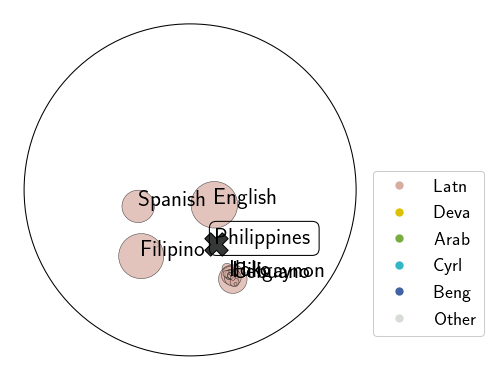

In [42]:
plot_languages_for_country('PH', 'Philippines', g, df_nodes_S1, df_features_S1, percent_speakers_show=0.1)

# plt.savefig("/home/rob/Dropbox/Robert/FeatureMercator/Paper/plots/unicodelang/S1_country_philippines.pdf")

en   English   Latn
sw   Swahili   Latn
mas   Masai   Latn
suk   Sukuma   Latn
nym   Nyamwezi   Latn
kde   Makonde   Latn
bez   Bena   Latn
ksb   Shambala   Latn
mgy   Mbunga   Latn
asa   Asu   Latn
lag   Langi   Latn
jmc   Machame   Latn
rof   Rombo   Latn
vun   Vunjo   Latn
rwk   Rwa   Latn
sbp   Sangu   Latn


/home/rob/.local/lib/python3.10/site-packages/matplotlib/text.py:905: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  x = float(self.convert_xunits(self._x))
/home/rob/.local/lib/python3.10/site-packages/matplotlib/text.py:906: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(self._y))
/home/rob/.local/lib/python3.10/site-packages/matplotlib/text.py:762: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posx = float(self.convert_xunits(x))
/home/rob/.local/lib/python3.10/site-packages/matplotlib/text.py:763: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posy = float(self.conve

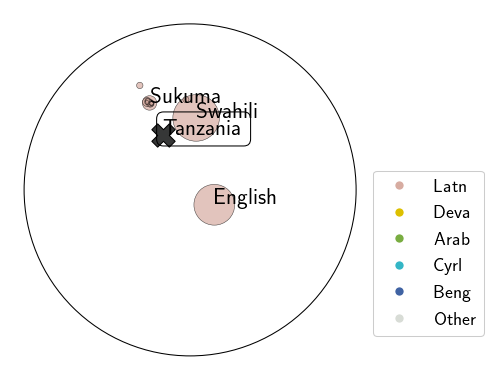

In [43]:
plot_languages_for_country('TZ', 'Tanzania', g, df_nodes_S1, df_features_S1, percent_speakers_show=0.05)

# plt.savefig("/home/rob/Dropbox/Robert/FeatureMercator/Paper/plots/unicodelang/S1_country_tanzania.pdf")

fr   French   Latn
en   English   Latn
sq   Albanian   Latn
el   Greek   Grek
mk   Macedonian   Cyrl
de   German   Latn
bg   Bulgarian   Cyrl
tr   Turkish   Latn
pnt   Pontic   Grek
tsd   Tsakonian   Grek
gmy   Mycenaean Greek   Linb
grc   Ancient Greek   Grek


/home/rob/.local/lib/python3.10/site-packages/matplotlib/text.py:905: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  x = float(self.convert_xunits(self._x))
/home/rob/.local/lib/python3.10/site-packages/matplotlib/text.py:906: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(self._y))
/home/rob/.local/lib/python3.10/site-packages/matplotlib/text.py:762: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posx = float(self.convert_xunits(x))
/home/rob/.local/lib/python3.10/site-packages/matplotlib/text.py:763: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posy = float(self.conve

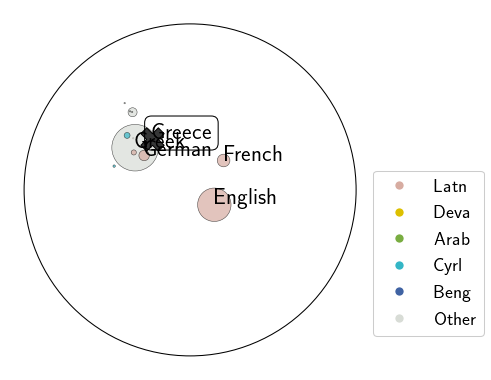

In [44]:
plot_languages_for_country('GR', 'Greece', g, df_nodes_S1, df_features_S1, percent_speakers_show=0.05)

# plt.savefig("/home/rob/Dropbox/Robert/FeatureMercator/Paper/plots/unicodelang/S1_country_greece.pdf")

es   Spanish   Latn
gn   Guarani   Latn
qu   Quechua   Latn
ay   Aymara   Latn
aro   Araona   Latn


/home/rob/.local/lib/python3.10/site-packages/matplotlib/text.py:905: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  x = float(self.convert_xunits(self._x))
/home/rob/.local/lib/python3.10/site-packages/matplotlib/text.py:906: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(self._y))
/home/rob/.local/lib/python3.10/site-packages/matplotlib/text.py:762: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posx = float(self.convert_xunits(x))
/home/rob/.local/lib/python3.10/site-packages/matplotlib/text.py:763: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posy = float(self.conve

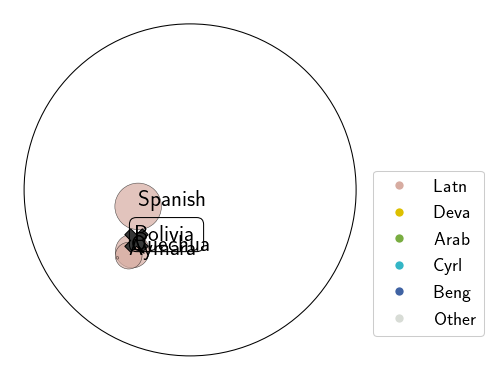

In [45]:
plot_languages_for_country('BO', 'Bolivia', g, df_nodes_S1, df_features_S1, percent_speakers_show=0.05)

# plt.savefig("/home/rob/Dropbox/Robert/FeatureMercator/Paper/plots/unicodelang/S1_country_bolivia.pdf")

In [46]:
df_nodes_S1

,index,inf_kappa,inf_theta,inf_radius,inf_kappa_le,inf_theta_le,inf_radius_le,Territory,Name,Population,...,alpha-2,alpha-3,country-code,iso_3166-2,region,sub-region,intermediate-region,region-code,sub-region-code,intermediate-region-code
0,AD,18.16440,1.864520,17.5722,10.30220,1.864520,18.7064,AD,Andorra,85370,...,AD,AND,20,ISO 3166-2:AD,Europe,Southern Europe,NaN,150.0,39.0,NaN
1,AE,28.55950,1.966690,16.6672,25.87300,1.966690,16.8648,AE,United Arab Emirates,10032200,...,AE,ARE,784,ISO 3166-2:AE,Asia,Western Asia,NaN,142.0,145.0,NaN
2,AF,58.90140,2.758470,15.2194,51.48520,2.758470,15.4886,AF,Afghanistan,40121600,...,AF,AFG,4,ISO 3166-2:AF,Asia,Southern Asia,NaN,142.0,34.0,NaN
3,AG,6.28175,1.178830,19.6959,6.07429,1.251530,19.7630,AG,Antigua & Barbuda,102634,...,AG,ATG,28,ISO 3166-2:AG,Americas,Latin America and the Caribbean,Caribbean,19.0,419.0,29.0
4,AI,1.05060,5.724600,23.2725,2.51949,5.951150,21.5231,AI,Anguilla,19416,...,AI,AIA,660,ISO 3166-2:AI,Americas,Latin America and the Caribbean,Caribbean,19.0,419.0,29.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241,YE,9.22097,0.954123,18.9282,6.07429,0.945032,19.7630,YE,Yemen,32140400,...,YE,YEM,887,ISO 3166-2:YE,Asia,Western Asia,NaN,142.0,145.0,NaN
242,YT,21.26350,1.189760,17.2572,15.06480,1.481400,17.9465,YT,Mayotte,194000,...,YT,MYT,175,ISO 3166-2:YT,Africa,Sub-Saharan Africa,Eastern Africa,2.0,202.0,14.0
243,ZA,107.54900,4.645340,14.0153,73.45380,4.393120,14.7779,ZA,South Africa,60442600,...,ZA,ZAF,710,ISO 3166-2:ZA,Africa,Sub-Saharan Africa,Southern Africa,2.0,202.0,18.0
244,ZM,27.66380,5.241640,16.7309,15.06480,4.929490,17.9465,ZM,Zambia,20799100,...,ZM,ZMB,894,ISO 3166-2:ZM,Africa,Sub-Saharan Africa,Eastern Africa,2.0,202.0,14.0


In [47]:
x_population = []
y_degree_country = []

for idx, row in df_nodes_S1.iterrows():
    p = row['Population']
    n = len(list(g.neighbors(row['index'])))
    x_population.append(p)
    y_degree_country.append(n)
    

In [48]:
tmp_df = pd.DataFrame({
    'population': x_population,
    'n_languages': y_degree_country,
})
tmp_df

,population,n_languages
0,85370,3
1,10032200,6
2,40121600,10
3,102634,2
4,19416,1
...,...,...
241,32140400,2
242,194000,4
243,60442600,13
244,20799100,4


In [49]:
tmp_df_sorted = tmp_df.sort_values('population')[::-1].reset_index().reset_index()
tmp_df_sorted.columns = ['rank', 'old_index', 'population', 'n_languages']
tmp_df_sorted['rank'] += 1
tmp_df_sorted

,rank,old_index,population,n_languages
0,1,46,1416040000,27
1,2,102,1409130000,79
2,3,229,341963000,28
3,4,98,281562000,30
4,5,174,252364000,24
...,...,...,...,...
241,242,228,316,1
242,243,212,140,1
243,244,177,50,1
244,245,88,20,1


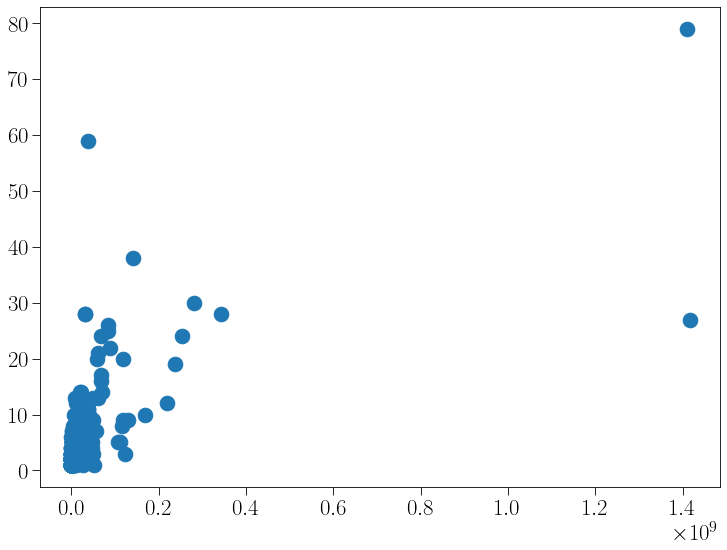

In [50]:
plt.scatter(tmp_df_sorted['population'], tmp_df_sorted['n_languages'])
# plt.xscale('log')
# plt.yscale('log')

In [51]:
speakers_dict_all = []
for idx, row in df_nodes_S1.iterrows():
    speakers = eval(row['Languages'])
    population = row['Population']
    speakers_dict = {l: p*population/100 for l, p in speakers}
    speakers_dict_all.append(speakers_dict)

In [52]:
speakers_per_language = {}

for dictionary in speakers_dict_all:
    for key, value in dictionary.items():
        speakers_per_language[key] = speakers_per_language.get(key, 0) + value

In [53]:
x_speakers = []
y_degree_lang = []
t_country = []

for idx, row in df_features_S1.iterrows():
    try:
        population_speaker = speakers_per_language[row['index']]
        t_country.append(row['index'])
        n = len(list(g.neighbors(row['index'])))
        x_speakers.append(population_speaker)
        y_degree_lang.append(n)
    except Exception:
        pass

In [54]:
tmp_df = pd.DataFrame({
    'population_speakers': x_speakers,
    'n_countries': y_degree_lang,
    'lang': t_country
})
tmp_df

,population_speakers,n_countries,lang
0,2.305972e+06,3,aa
1,1.118589e+05,2,ab
2,7.863420e+06,2,af
3,1.348975e+07,1,ak
4,3.917698e+07,2,am
...,...,...,...
711,1.831992e+06,1,rif_Tfng
712,3.252721e+06,1,shi_Latn
713,5.602032e+03,1,unr_Deva
714,0.000000e+00,1,vai_Latn


In [55]:
tmp_df_sorted = tmp_df.sort_values('population_speakers')[::-1].reset_index().reset_index()
tmp_df_sorted.columns = ['rank', 'old_index', 'population_speakers', 'n_countries', 't_country']
tmp_df_sorted['rank'] += 1
tmp_df_sorted

,rank,old_index,population_speakers,n_countries,t_country
0,1,35,1.727284e+09,146,en
1,2,172,1.286095e+09,7,zh
2,3,55,5.796978e+08,6,hi
3,4,37,5.043367e+08,37,es
4,5,6,3.784822e+08,38,ar
...,...,...,...,...,...
711,712,360,0.000000e+00,1,jbo
712,713,651,0.000000e+00,1,vot
713,714,515,0.000000e+00,1,osa
714,715,524,0.000000e+00,1,pfl


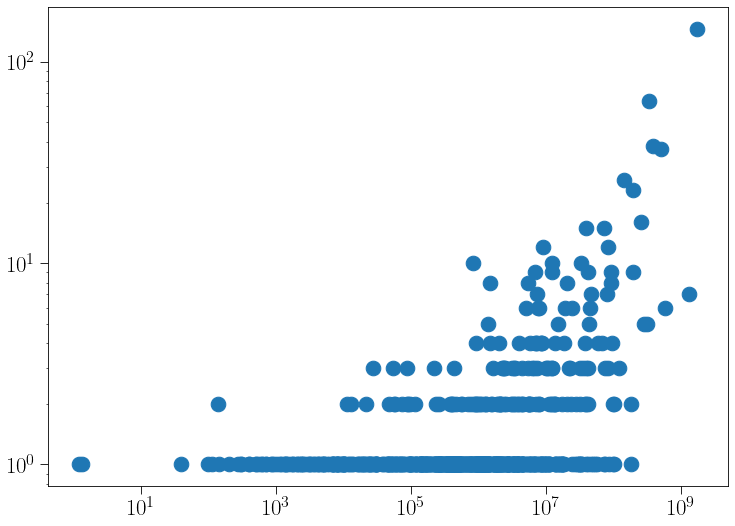

In [56]:
plt.scatter(tmp_df_sorted['population_speakers'], tmp_df_sorted['n_countries'])
plt.xscale('log')
plt.yscale('log')

---
---

In [463]:
def get_language_profile(lang_name):
    angles = []

    lang_angular_pos = df_features_S1[df_features_S1['index'] == lang_name]['inf_theta'].values[0]

    for country in g.neighbors(lang_name):
        tmp = df_nodes_S1[df_nodes_S1['index'] == country]
        angular_pos = tmp['inf_theta'].values[0]
        angular_pos = np.pi - np.fabs(np.pi - np.fabs(angular_pos - lang_angular_pos))
#         angular_pos = angular_pos - lang_angular_pos
        angles.append(angular_pos)
    
    return np.array(angles)

In [464]:
lang_degrees = []
for l in df_features_S1['index']:
    try:
        lang_degrees.append((l, len(list(g.neighbors(l)))))
    except Exception as e:
        print(e)
    
N = 15
sorted_data = sorted(lang_degrees, key=lambda x: x[1], reverse=True)
top_N = [item[0] for item in sorted_data[:N]]

df_selected_lang = df_features_S1.set_index('index').loc[top_N].reset_index()
selected_lang_names = dict(df_selected_lang[['index', 'Language Name']].values)

selected_lang_scripts = []
for s in df_selected_lang['Scripts'].values:
    tmp_script = s
    if not pd.notna(s):
        tmp_script = 'Other'    
    if s == 'Laoo':
        tmp_script = 'Lao'
    selected_lang_scripts.append(tmp_script)

selected_languages = df_selected_lang['index'].values
selected_languages

The node nan is not in the graph.


array(['en', 'fr', 'ar', 'es', 'de', 'ru', 'pt', 'it', 'zh_Hant', 'ff',
       'tr', 'ff_Adlm', 'el', 'nl', 'hnj'], dtype=object)

In [465]:
# for c in list(g.neighbors('ff_Adlm')):
#     print(df_nodes_S1[df_nodes_S1['index'] == c])

In [466]:
tmp_colormap = [
  "#a00e00",
  "#d04e00",
  "#f6c200",
  "#0086a8",
  "#132b69"
][::-1]
script_colors_mapping = {s: c for c, s in zip(tmp_colormap, np.unique(selected_lang_scripts))}
script_colors_mapping['Other'] = 'xkcd:grey'

In [467]:
df_selected_lang['Scripts'].values

array(['Latn', 'Latn', 'Arab', 'Latn', 'Latn', 'Cyrl', 'Latn', 'Latn',
       nan, 'Latn', 'Latn', nan, 'Grek', 'Latn', 'Laoo'], dtype=object)

In [468]:
selected_lang_names.values()

dict_values(['English', 'French', 'Arabic', 'Spanish', 'German', 'Russian', 'Portuguese', 'Italian', 'Chinese (Traditional)', 'Fula', 'Turkish', 'Fula (Adlam)', 'Greek', 'Dutch', 'Hmong Njua'])

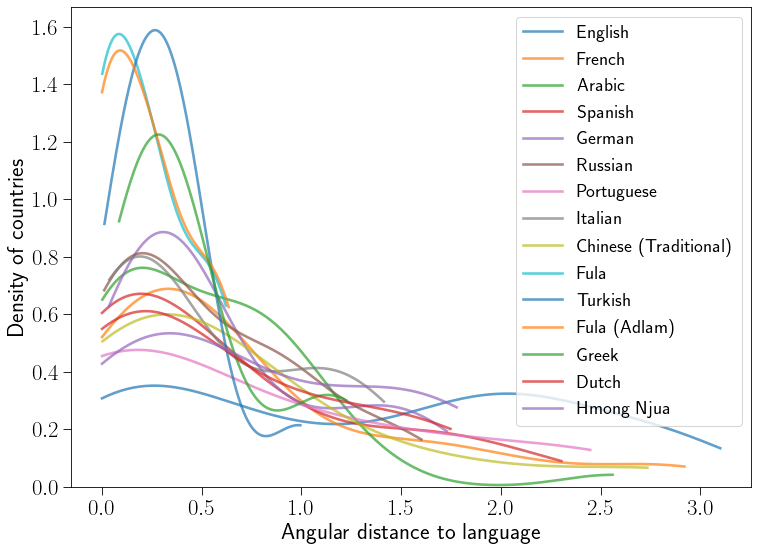

In [469]:
all_lang_profiles = []

for lang in selected_languages:
    
    lang_profile = get_language_profile(lang)
    all_lang_profiles.append(lang_profile)
    
    sns.kdeplot(lang_profile, alpha=0.7, 
                clip=(lang_profile.min(), lang_profile.max()), label=selected_lang_names[lang])

plt.xlabel('Angular distance to language')
plt.ylabel('Density of countries')
plt.legend()

In [470]:
script_long_names = {
    'Arab': 'Arabic',
    'Cyrl': 'Cyrlic',
    'Grek': 'Greek',
    'Lao': 'Lao',
    'Latn': 'Latin',
    'Other': 'Other'
}

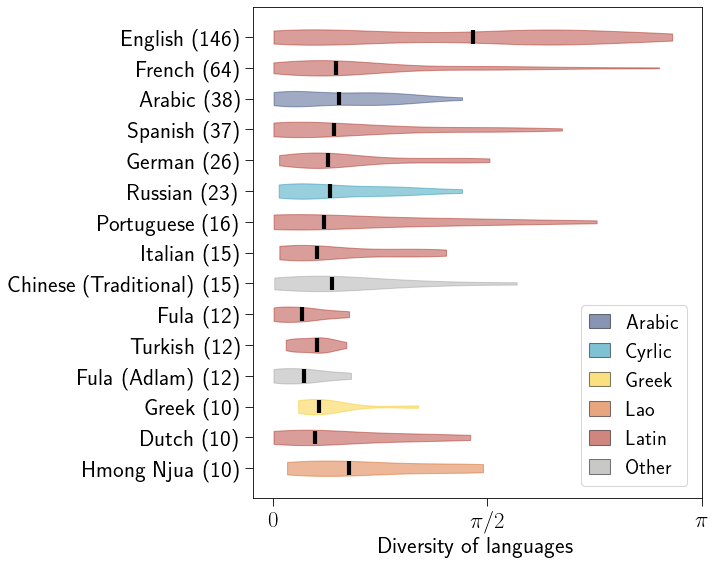

In [472]:
import matplotlib.patches as mpatches

fig, ax = plt.subplots(figsize=(10, 8))

filtered_lang_profiles = []
for profile in all_lang_profiles:
    lower = np.percentile(profile, 2.5)
    upper = np.percentile(profile, 97.5)
    filtered_profile = profile[(profile >= lower) & (profile <= upper)]
    filtered_lang_profiles.append(filtered_profile)

reversed_profiles = filtered_lang_profiles[::-1]
tmp_labels = list(selected_lang_names.values())[::-1]
scripts_reversed = selected_lang_scripts[::-1]

parts = ax.violinplot(reversed_profiles, showmedians=True, vert=False, 
                      showextrema=False)

for i, body in enumerate(parts['bodies']):
    script = scripts_reversed[i]
    color = script_colors_mapping.get(script, 'k')
    body.set_facecolor(color)
    body.set_edgecolor(color)
    body.set_alpha(0.4)

for key in ['cbars', 'cmins', 'cmaxes']:
    if key in parts:
        colors = [script_colors_mapping.get(script, 'k') for script in scripts_reversed]
        parts[key].set_color(colors)
        parts[key].set_linewidth(3)

parts['cmedians'].set_visible(False)
for i, profile in enumerate(reversed_profiles):
    median = np.median(profile)
    y_center = i + 1
    extension = 0.22
    y_min = y_center - extension
    y_max = y_center + extension
    ax.vlines(median, y_min, y_max, color='k', linewidth=4)
    
    
node_degrees = [x[1] for x in sorted_data[:N]][::-1]
tmp_labels_with_degrees = [f'{l} ({d})' for l, d in zip(tmp_labels, node_degrees)]

ax.set_yticks(range(1, len(tmp_labels) + 1))
ax.set_yticklabels(tmp_labels_with_degrees, rotation=0, ha="right")
ax.set_xticks([0, np.pi/2, np.pi], ['$0$', '$\pi/2$', r'$\pi$'])
ax.set_xlabel('Diversity of languages')

legend_handles = [mpatches.Patch(facecolor=color, edgecolor='black', label=script_long_names[script], alpha=0.5)
                  for script, color in script_colors_mapping.items()]

ax.legend(handles=legend_handles, loc=(0.73, 0.025), handlelength=1, fontsize=20)

plt.tight_layout()

# plt.savefig("/home/rob/Dropbox/Robert/FeatureMercator/Paper/plots/language_profiles_new.pdf")

In [473]:
import itertools

def angular_distance(x1, x2):
    """
    Computes the circular distance between two angles using:
    distance = np.pi - np.fabs(np.pi - np.fabs(x1 - x2))
    """
    return np.pi - np.abs(np.pi - np.abs(x1 - x2))

In [474]:
degrees = []
all_max_pos = []


for l in df_features_S1.sort_values('inf_kappa')[::-1].head(20)['index'].values:
    nb = list(g.neighbors(l))
    degrees.append(len(nb))
    
    all_pos = []
    
    for country in nb:
        # Only consider nodes with degree>1
        if len(list(g.neighbors(country))) > 0:
            tmp = df_nodes_S1[df_nodes_S1['index'] == country]
            angular_pos = tmp['inf_theta'].values[0]
            all_pos.append(angular_pos)
        
    max_distance = max(angular_distance(x, y) for x, y in itertools.combinations(all_pos, 2))
    all_max_pos.append(max_distance)
    

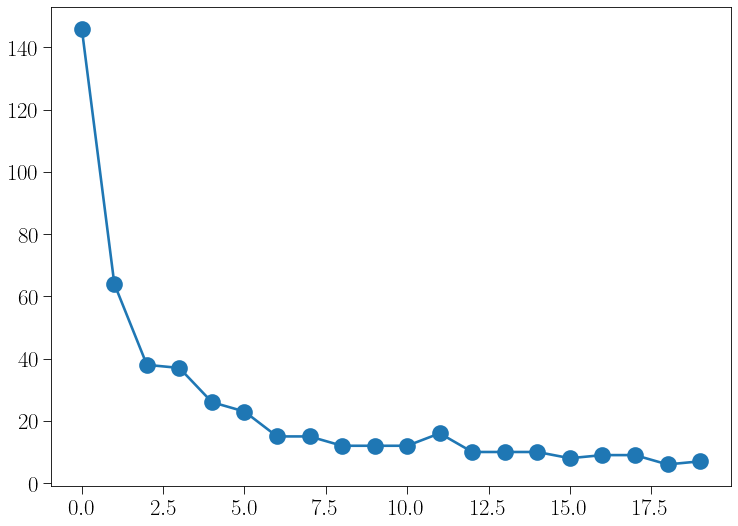

In [475]:
plt.plot(degrees, 'o-')

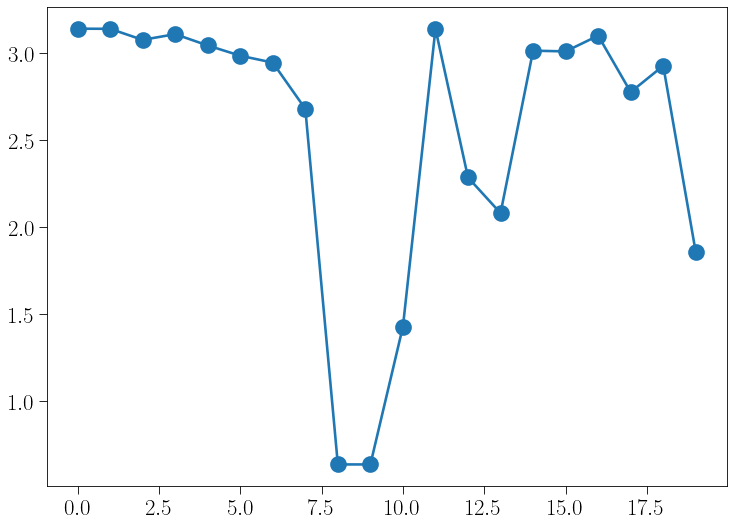

In [476]:
plt.plot(all_max_pos, 'o-')


The same for countries

---
---

In [477]:
def get_country_profile(country_name):
    angles = []
    country_angular_pos = df_nodes_S1[df_nodes_S1['index'] == country_name]['inf_theta'].values[0]

    for lang in g.neighbors(country_name):
        try:

            tmp = df_features_S1[df_features_S1['index'] == lang]
            angular_pos = tmp['inf_theta'].values[0]
            angular_pos = np.pi - np.fabs(np.pi - np.fabs(angular_pos - country_angular_pos))
    #         angular_pos = angular_pos - lang_angular_pos
            angles.append(angular_pos)
        except Exception as e:
            print(lang)
    
    return np.array(angles)

In [478]:
country_degrees = []
for c in df_nodes_S1['index']:
    country_degrees.append((c, len(list(g.neighbors(c)))))
    
N = 15
sorted_data = sorted(country_degrees, key=lambda x: x[1], reverse=True)
top_N = [item[0] for item in sorted_data[:N]]

df_selected_countries = df_nodes_S1.set_index('index').loc[top_N].reset_index()
selected_country_names = dict(df_selected_countries[['index', 'Name']].values)

selected_countries = df_selected_countries['index'].values
selected_countries

array(['IN', 'CA', 'RU', 'ID', 'CM', 'NP', 'US', 'CN', 'TR', 'DE', 'GB',
       'PK', 'IR', 'IT', 'KE'], dtype=object)

In [479]:
# sorted_data

In [480]:
region_colors = [
    "#e76254", "#ef8a47", "#f7aa58", "#ffd06f", "#ffe6b7",
    "#aadce0", "#72bcd5", "#528fad", "#376795", "#1e466e"
][::2]
    
selected_country_regions = df_selected_countries['region'].values

region_colors_mapping = {r: c for r, c in zip(np.unique(selected_country_regions), region_colors)}

nan


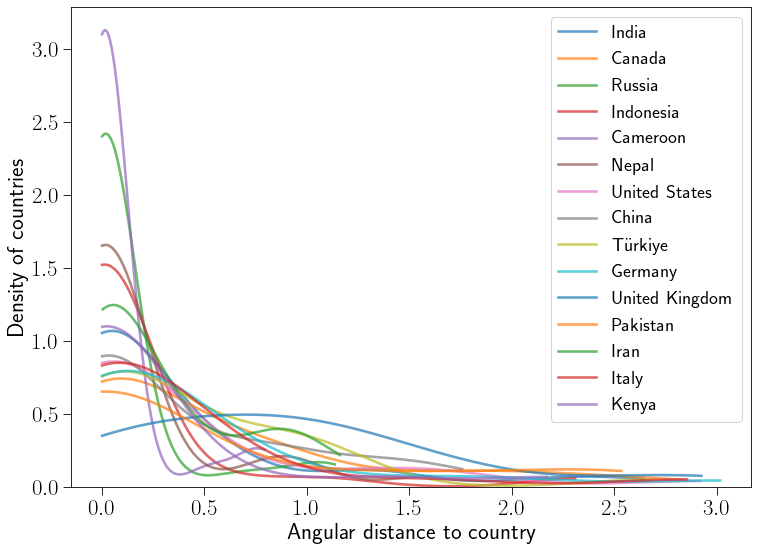

In [481]:
all_country_profiles = []

for c in selected_countries:
    
    country_profile = get_country_profile(c)
    all_country_profiles.append(country_profile)
    
    sns.kdeplot(country_profile, alpha=0.7, 
                clip=(country_profile.min(), country_profile.max()), label=selected_country_names[c])

plt.xlabel('Angular distance to country')
plt.ylabel('Density of countries')
plt.legend()

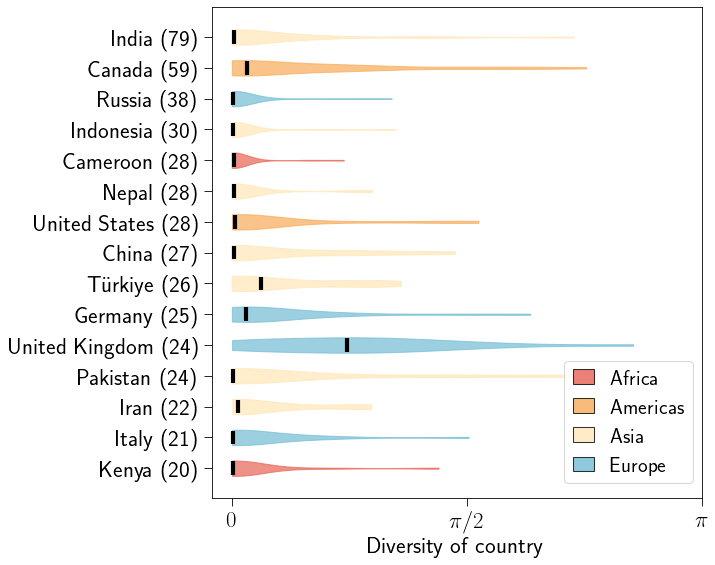

In [486]:
import matplotlib.patches as mpatches

fig, ax = plt.subplots(figsize=(10, 8))


filtered_country_profiles = []
for profile in all_country_profiles:
    lower = np.percentile(profile, 2.5)
    upper = np.percentile(profile, 97.5)
    filtered_profile = profile[(profile >= lower) & (profile <= upper)]
    filtered_country_profiles.append(filtered_profile)

reversed_profiles = filtered_country_profiles[::-1]
tmp_labels = list(selected_country_names.values())[::-1]
regions_reversed = selected_country_regions[::-1]

parts = ax.violinplot(reversed_profiles, showmedians=True, vert=False, showextrema=False)

# Color each violin using the mapping.
for i, body in enumerate(parts['bodies']):
    region = regions_reversed[i]
    color = region_colors_mapping.get(region, 'k')
    body.set_facecolor(color)
    body.set_edgecolor(color)
    body.set_alpha(0.7)

for key in ['cmedians', 'cbars', 'cmins', 'cmaxes']:
    if key in parts:
        colors = [region_colors_mapping.get(region, 'k') for region in regions_reversed]
        parts[key].set_color(colors)
        parts[key].set_linewidth(3)

parts['cmedians'].set_visible(False)
for i, profile in enumerate(reversed_profiles):
    median = np.median(profile)
    y_center = i + 1
    extension = 0.22
    y_min = y_center - extension
    y_max = y_center + extension
    ax.vlines(median, y_min, y_max, color='k', linewidth=4)


        
node_degrees = [x[1] for x in sorted_data[:N]][::-1]
tmp_labels_with_degrees = [f'{l} ({d})' for l, d in zip(tmp_labels, node_degrees)]

ax.set_yticks(range(1, len(tmp_labels) + 1))
ax.set_yticklabels(tmp_labels_with_degrees, rotation=0, ha="right")
ax.set_xticks([0, np.pi/2, np.pi], ['$0$', '$\pi/2$', r'$\pi$'])
ax.set_xlabel('Diversity of country')

legend_handles = [mpatches.Patch(facecolor=color, edgecolor='black', label=region, alpha=0.8)
                  for region, color in region_colors_mapping.items()]

ax.legend(handles=legend_handles, loc=(0.72, 0.03), handlelength=1, fontsize=20)

plt.tight_layout()

# plt.savefig("/home/rob/Dropbox/Robert/FeatureMercator/Paper/plots/country_profiles_new.pdf")

In [483]:
# TODO: